⏳ Loading datasets...
📊 Generating comparison for 28 parameters...


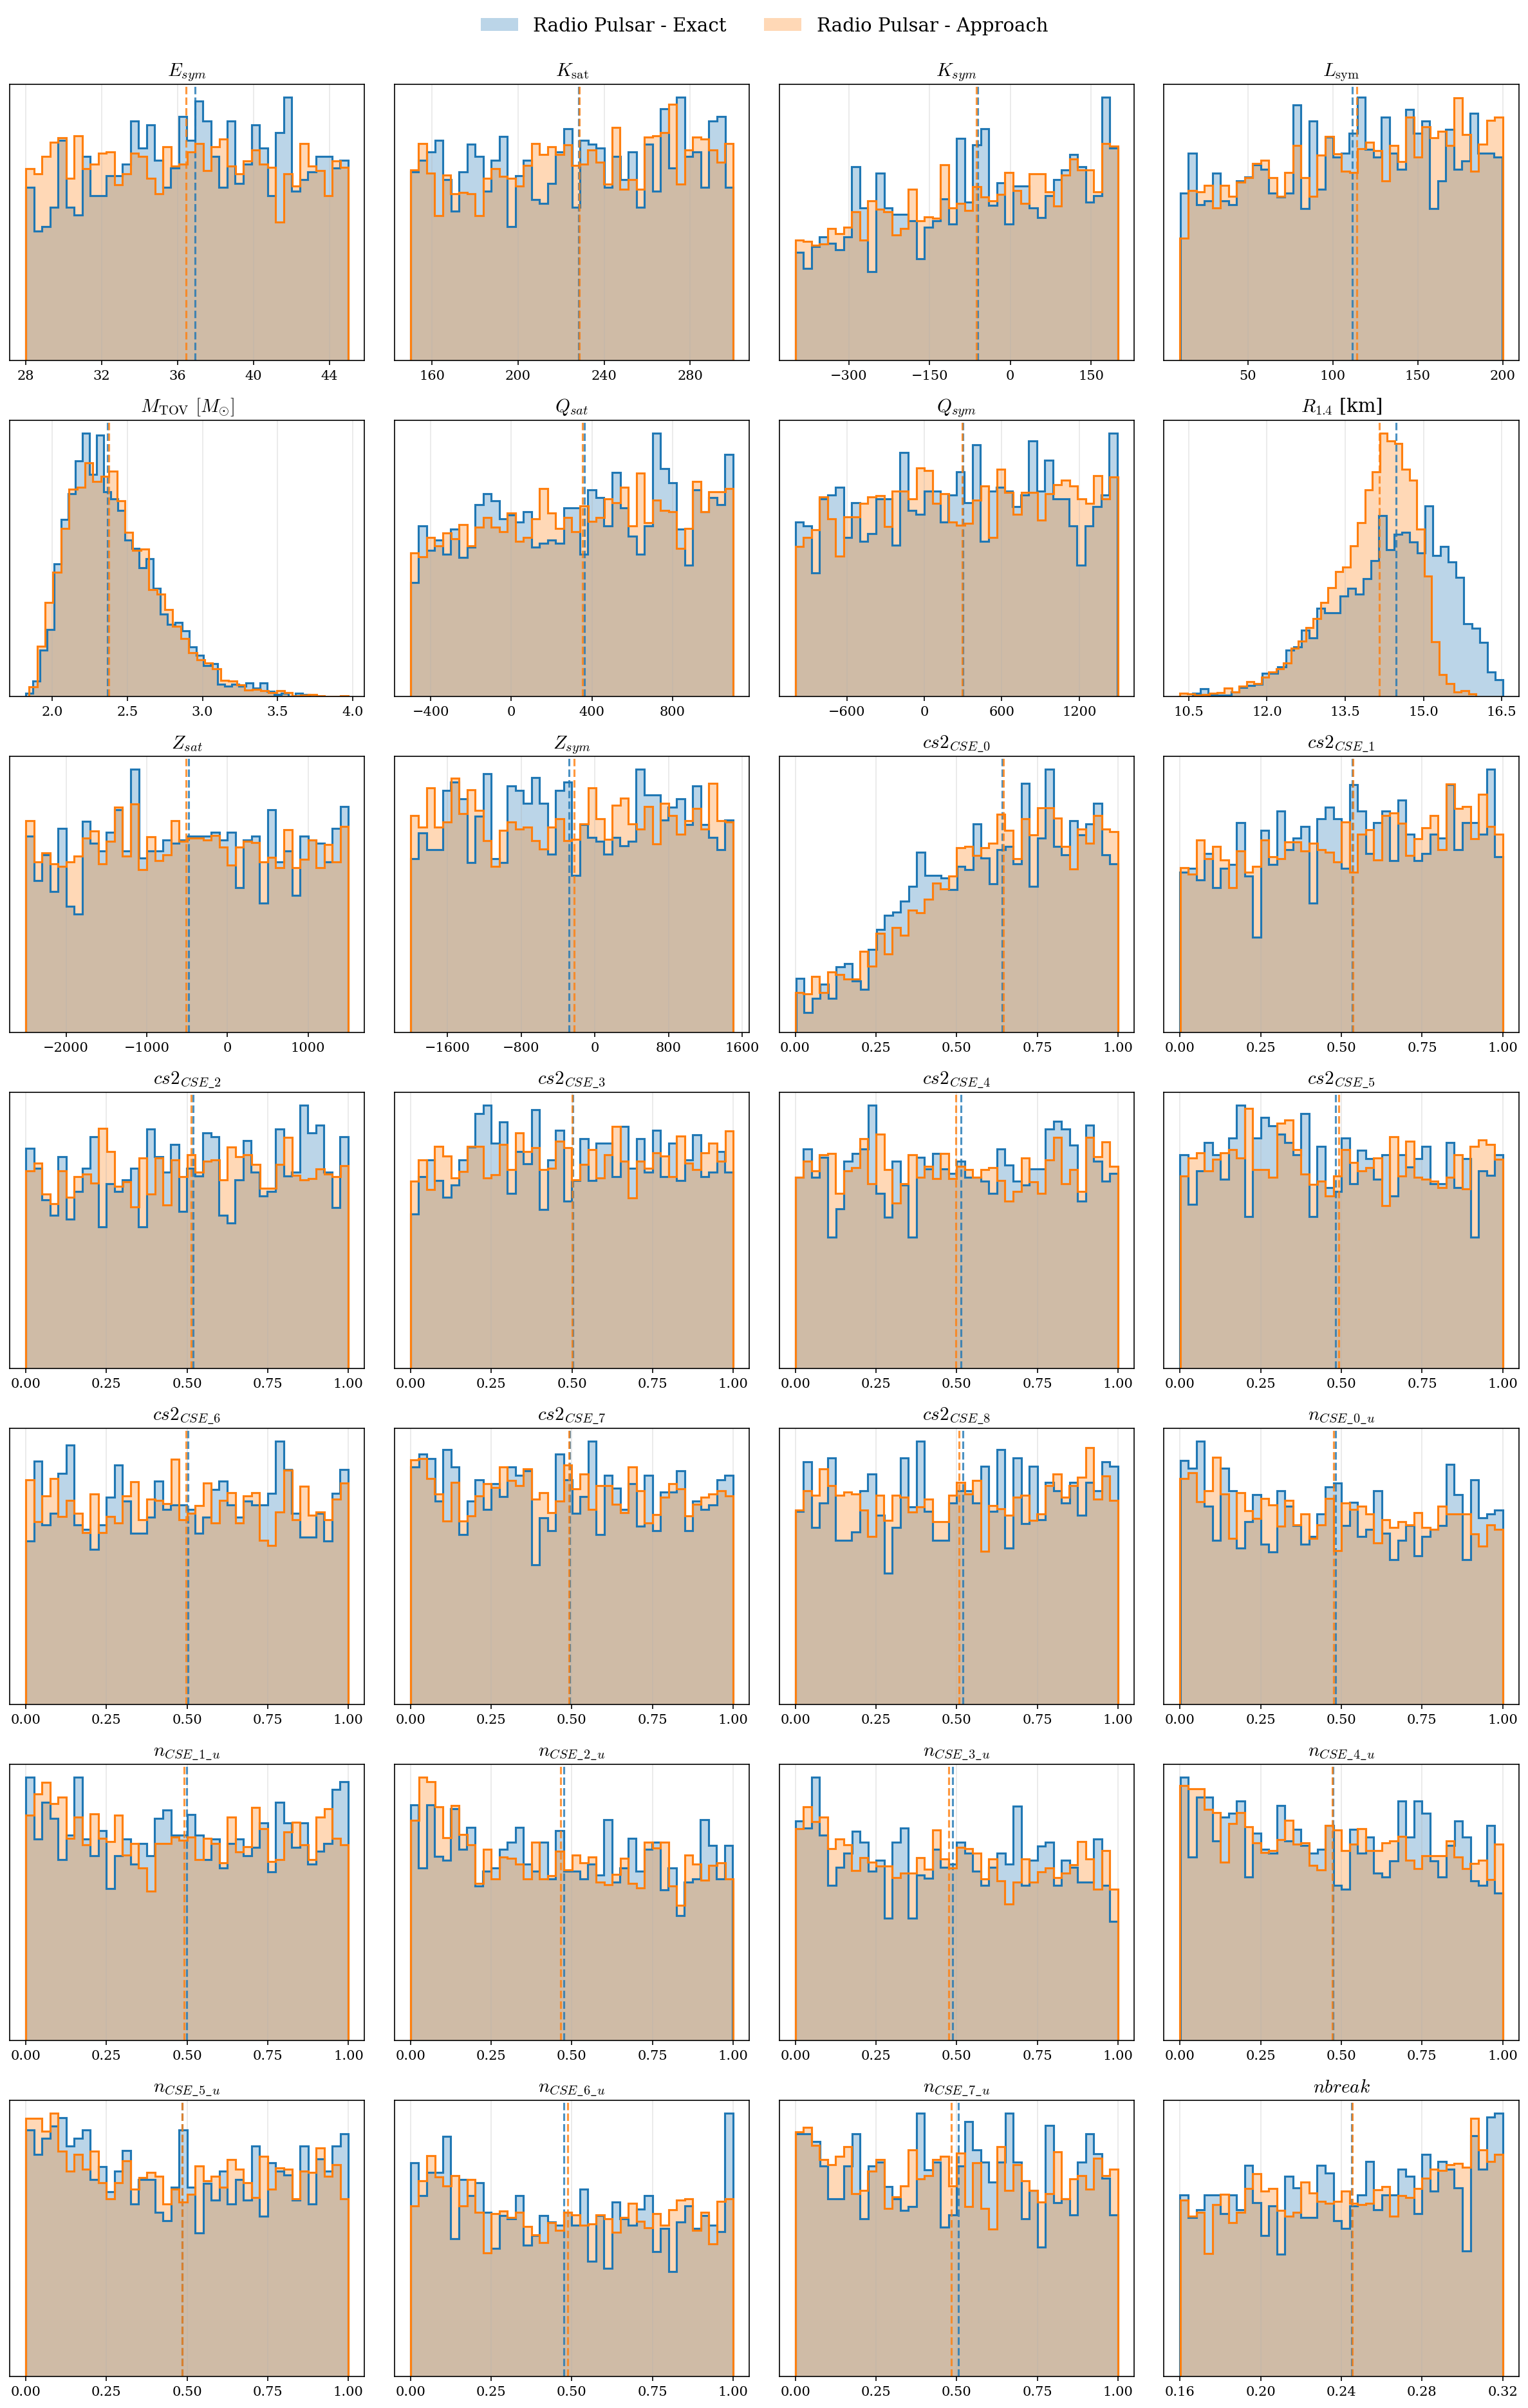

In [1]:
"""
Comparison Script for EOS Inference Results.
Automatically detects overlapping parameters and plots comparative histograms.
"""

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import logging
from scipy.stats import gaussian_kde
from matplotlib.ticker import MaxNLocator

# ==============================================================================
#                               USER CONFIGURATION
# ==============================================================================

FILE_1 = "smc_random_walk_exact_betaeq/radio/outdir/results.h5"
FILE_2 = "smc_random_walk/radio/outdir/results.h5"  # Comparison file

LABELS = ["Radio Pulsar - Exact", "Radio Pulsar - Approach"]  # Legend labels
COLORS = ["#1f77b4", "#ff7f0e"]  # Blue vs Orange (Standard accessible contrast)

PLOT_CONFIG = {
    "DPI": 150,
    "FIG_WIDTH": 16,     # Total width of the figure
    "COLS": 4,           # Number of columns in the subplot grid
    "BINS": 40,
    "USE_TEX": True
}

# ==============================================================================
#                                 CORE LOGIC
# ==============================================================================

logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger("comparator")

def setup_matplotlib():
    """Configures plot aesthetics."""
    plt.rcParams.update({
        "axes.grid": True, "grid.alpha": 0.3, "axes.labelsize": 12,
        "xtick.labelsize": 10, "ytick.labelsize": 10, "legend.fontsize": 10,
        "figure.titlesize": 16, "mathtext.fontset": "cm", "font.family": "serif"
    })
    if PLOT_CONFIG["USE_TEX"]:
        try:
            from matplotlib.checkdep_usetex import checkdep_usetex
            if checkdep_usetex(True):
                plt.rcParams.update({"text.usetex": True})
        except:
            pass

def get_fancy_label(name):
    """Generates LaTeX labels for parameters."""
    MAPPING = {
        'M_TOV': r'$M_{\rm{TOV}}$ $[M_{\odot}]$', 'R_1.4': r'$R_{1.4}$ [km]',
        'P_3nsat': r'$P(3n_{\rm{sat}})$ [MeV fm$^{-3}$]', 'L_sym': r'$L_{\rm{sym}}$',
        'K_sat': r'$K_{\rm{sat}}$', 'chi2': r'$\chi^2$', 'log_prob': r'$\ln \mathcal{L}$'
    }
    if name in MAPPING: return MAPPING[name]
    
    # Handle Greek letters and underscores
    parts = name.split('_')
    base = parts[0]
    if base in ['alpha', 'beta', 'gamma', 'delta', 'rho', 'sigma', 'kappa', 'lambda', 'epsilon']:
        base = f"\\{base}"
    
    if len(parts) > 1:
        sub = r'\_'.join(parts[1:])
        return f"${base}_{{{sub}}}$"
    return f"${base}$"

def load_params(filepath):
    """Loads parameters and computes derived scalars (M_TOV, etc) if missing."""
    if not os.path.exists(filepath):
        logger.warning(f"⚠️ File not found: {filepath}")
        return None

    with h5py.File(filepath, 'r') as f:
        if 'posterior' not in f: return None
        post = f['posterior']
        
        # Load explicit parameters
        data = {}
        if 'parameters' in post:
            for k in post['parameters'].keys():
                data[k] = post['parameters'][k][:]

        # Load or Compute Derived Scalars
        # We try to grab pre-computed ones, or compute from arrays if necessary
        eos_group = post.get('derived_eos', post)
        
        if 'M_TOV' not in data:
            # Quick computation of M_TOV from mass arrays if not stored as scalar
            try:
                masses = eos_group.get('masses_EOS', eos_group.get('masses'))[:]
                data['M_TOV'] = np.max(masses, axis=1)
            except: pass

        if 'R_1.4' not in data:
            try:
                masses = eos_group.get('masses_EOS', eos_group.get('masses'))[:]
                radii = eos_group.get('radii_EOS', eos_group.get('radii'))[:]
                r14 = []
                for m, r in zip(masses, radii):
                    # Sort to ensure interpolation works
                    srt = np.argsort(m)
                    r14.append(np.interp(1.4, m[srt], r[srt]))
                data['R_1.4'] = np.array(r14)
            except: pass

    return data

def plot_comparison(data1, data2):
    """Plots comparative histograms for all detected parameters."""
    
    # 1. Identify all unique keys
    keys1 = set(data1.keys()) if data1 else set()
    keys2 = set(data2.keys()) if data2 else set()
    all_keys = sorted(list(keys1.union(keys2)))
    
    # Filter out non-scalar arrays (just in case raw EOS curves got mixed in)
    valid_keys = []
    for k in all_keys:
        is_valid = False
        if k in keys1 and data1[k].ndim == 1: is_valid = True
        elif k in keys2 and data2[k].ndim == 1: is_valid = True
        
        # Skip constants (std dev == 0) to avoid plotting errors
        if is_valid:
            s1 = np.std(data1[k]) if k in keys1 else 1
            s2 = np.std(data2[k]) if k in keys2 else 1
            if s1 > 1e-12 or s2 > 1e-12:
                valid_keys.append(k)

    if not valid_keys:
        logger.error("❌ No valid 1D parameters found to compare.")
        return

    # 2. Setup Subplots
    n_plots = len(valid_keys)
    cols = PLOT_CONFIG["COLS"]
    rows = (n_plots + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(PLOT_CONFIG["FIG_WIDTH"], rows * 3.5), dpi=PLOT_CONFIG["DPI"])
    axes = axes.flatten() if n_plots > 1 else [axes]

    logger.info(f"📊 Generating comparison for {n_plots} parameters...")

    for i, param in enumerate(valid_keys):
        ax = axes[i]
        
        # --- Plot File 1 ---
        if k in keys1 and param in keys1:
            d1 = data1[param]
            # Remove NaNs/Infs
            d1 = d1[np.isfinite(d1)]
            
            # Histogram
            ax.hist(d1, bins=PLOT_CONFIG["BINS"], density=True, 
                    color=COLORS[0], alpha=0.3, label=LABELS[0] if i==0 else "")
            ax.hist(d1, bins=PLOT_CONFIG["BINS"], density=True, 
                    color=COLORS[0], histtype='step', linewidth=1.5)
            
            # Median Line
            ax.axvline(np.median(d1), color=COLORS[0], linestyle='--', alpha=0.8)

        # --- Plot File 2 ---
        if keys2 and param in keys2:
            d2 = data2[param]
            d2 = d2[np.isfinite(d2)]
            
            ax.hist(d2, bins=PLOT_CONFIG["BINS"], density=True, 
                    color=COLORS[1], alpha=0.3, label=LABELS[1] if i==0 else "")
            ax.hist(d2, bins=PLOT_CONFIG["BINS"], density=True, 
                    color=COLORS[1], histtype='step', linewidth=1.5)
            
            ax.axvline(np.median(d2), color=COLORS[1], linestyle='--', alpha=0.8)

        # Formatting
        ax.set_title(get_fancy_label(param), fontsize=14)
        ax.set_yticks([])
        ax.xaxis.set_major_locator(MaxNLocator(nbins=5)) # Prevent crowded x-ticks

    # Cleanup empty axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Global Legend
    if keys2:
        fig.legend(loc='upper center', ncol=2, frameon=False, fontsize=14, bbox_to_anchor=(0.5, 1.02))
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    setup_matplotlib()
    
    logger.info("⏳ Loading datasets...")
    d1 = load_params(FILE_1)
    d2 = load_params(FILE_2)

    if d1 is None and d2 is None:
        logger.error("💀 Bro, both files are missing or invalid. Check your paths!")
    elif d1 is None:
        logger.info("⚠️ File 1 missing. Plotting File 2 only.")
        plot_comparison({}, d2)
    elif d2 is None:
        logger.info("⚠️ File 2 missing. Plotting File 1 only.")
        plot_comparison(d1, {})
    else:
        plot_comparison(d1, d2)

⏳ Loading datasets...
📊 Generating comparison for 28 parameters...


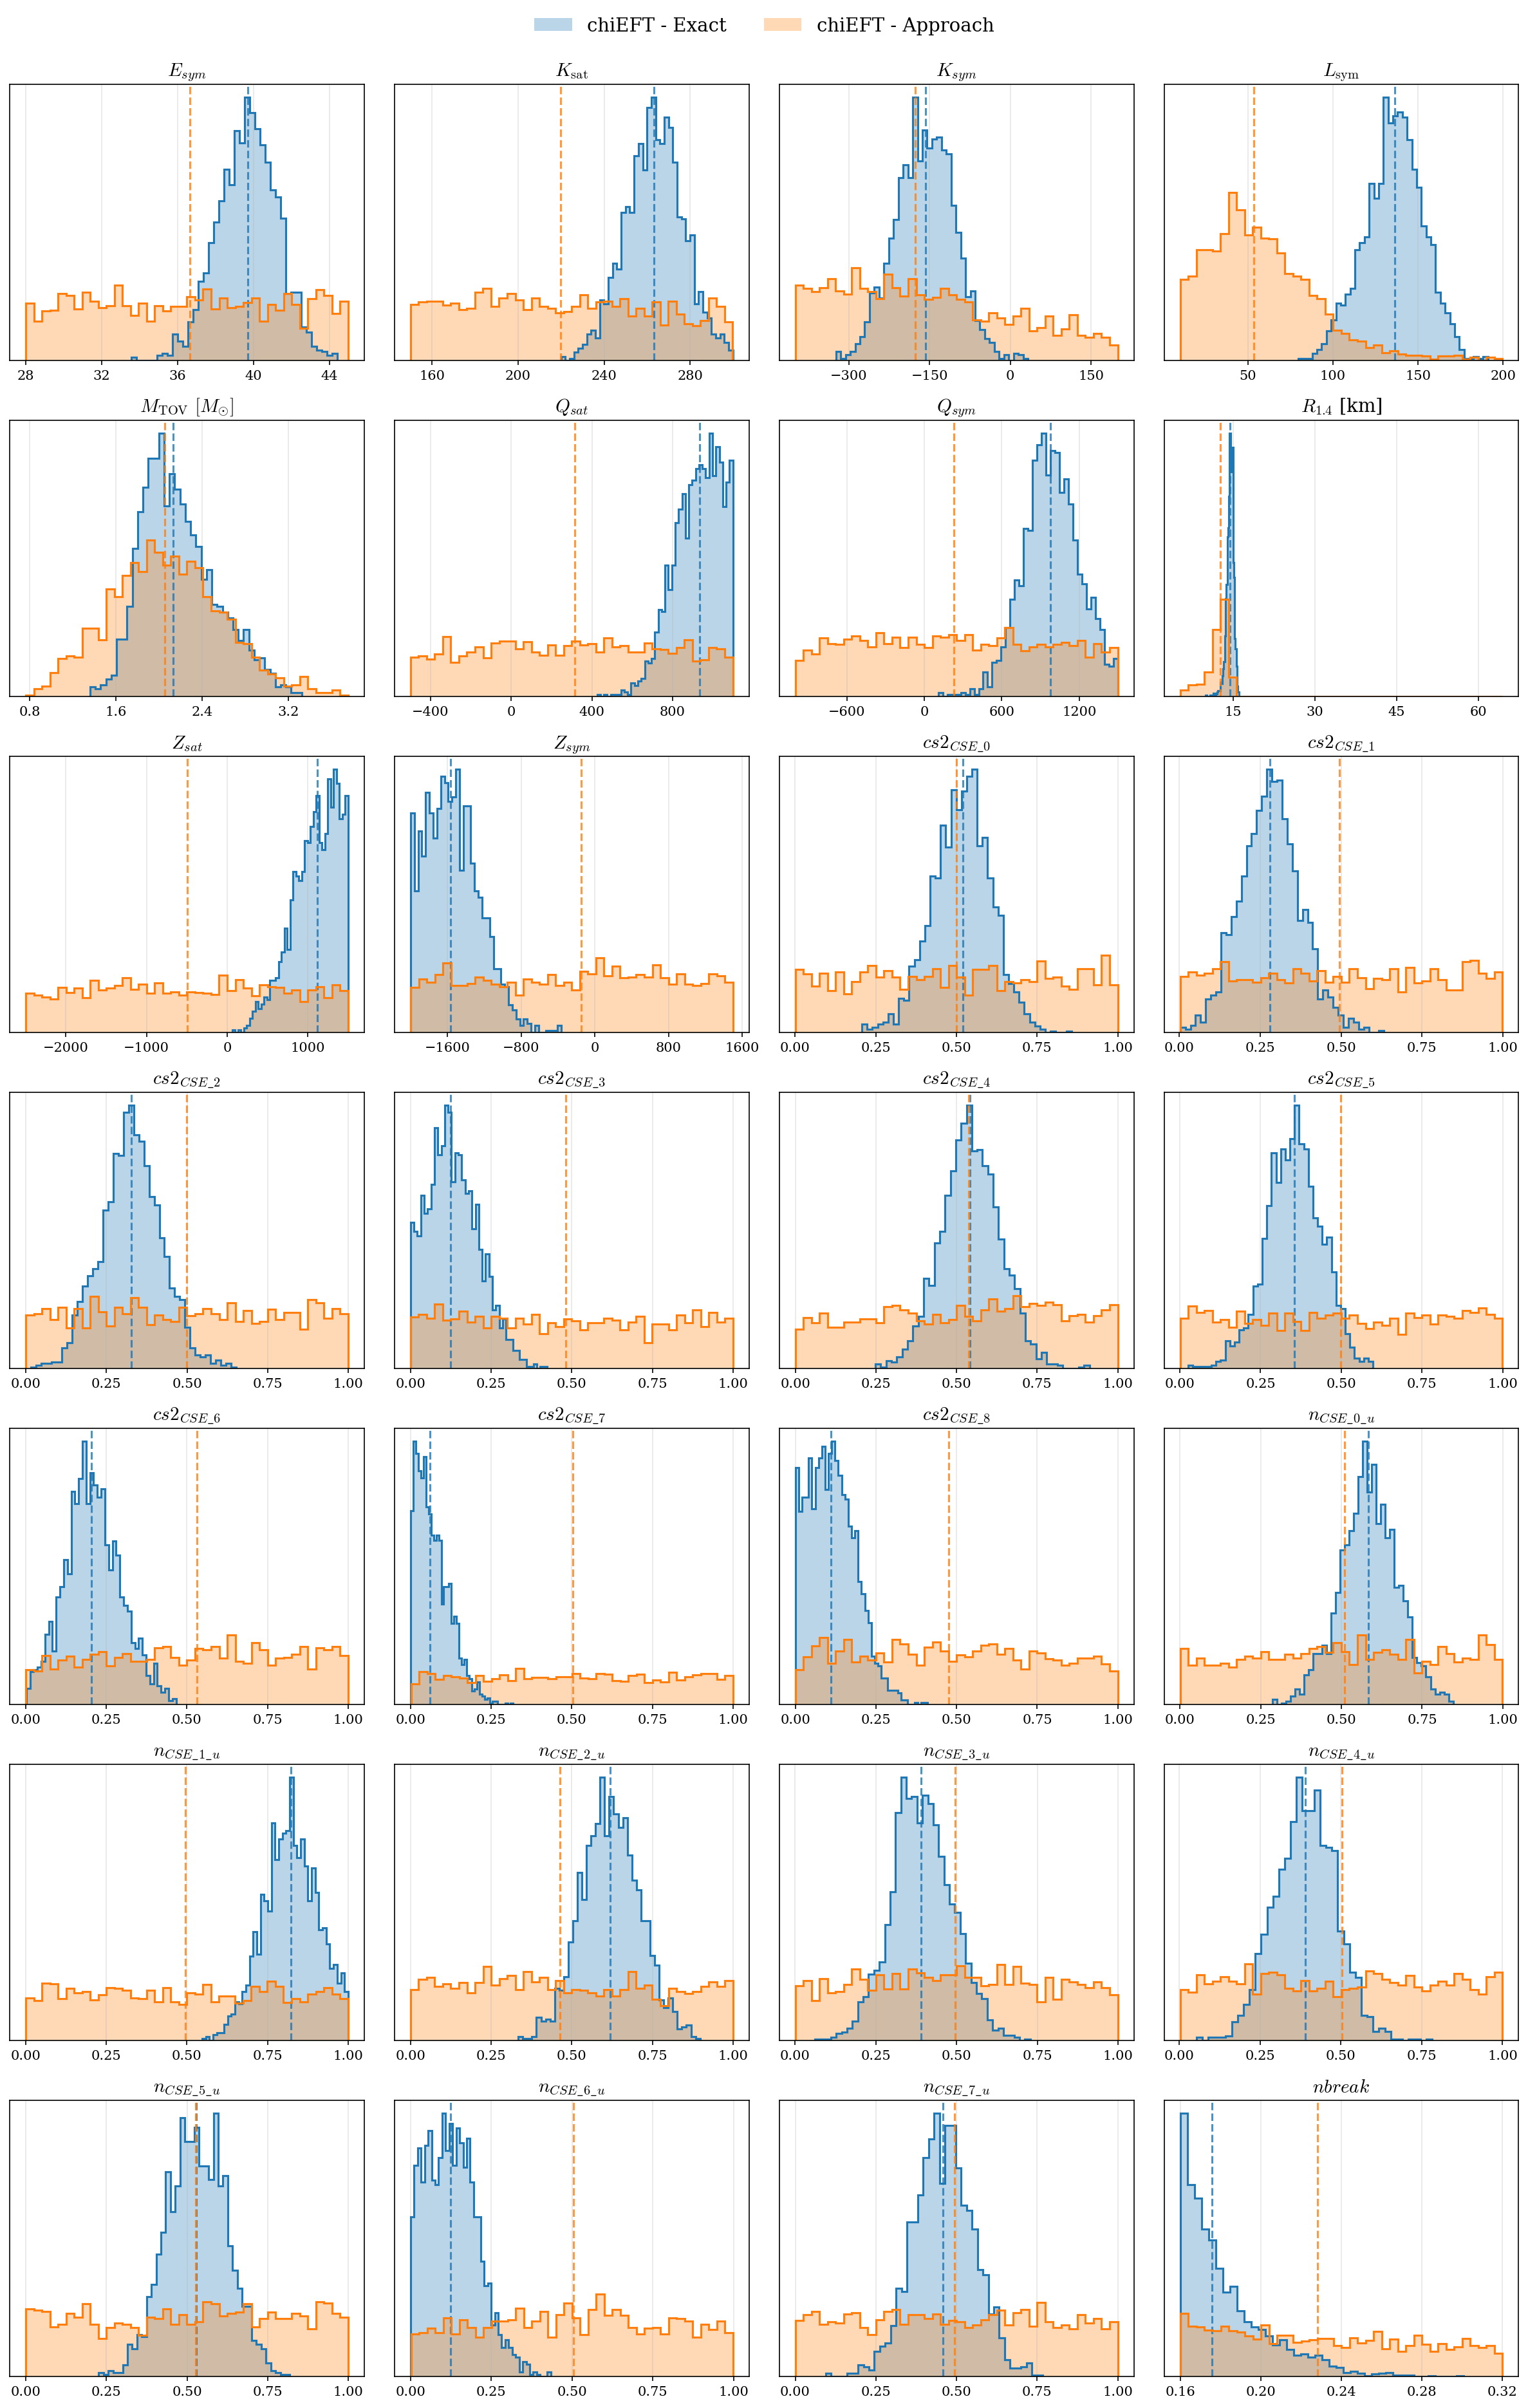

In [12]:
"""
Comparison Script for EOS Inference Results.
Automatically detects overlapping parameters and plots comparative histograms.
"""

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import logging
from scipy.stats import gaussian_kde
from matplotlib.ticker import MaxNLocator

# ==============================================================================
#                               USER CONFIGURATION
# ==============================================================================

FILE_1 = "smc_random_walk_exact_betaeq/chiEFT/outdir/results.h5"
FILE_2 = "smc_random_walk/chiEFT/outdir/results.h5"  # Comparison file

LABELS = ["chiEFT - Exact", "chiEFT - Approach"]  # Legend labels
COLORS = ["#1f77b4", "#ff7f0e"]  # Blue vs Orange (Standard accessible contrast)

PLOT_CONFIG = {
    "DPI": 150,
    "FIG_WIDTH": 16,     # Total width of the figure
    "COLS": 4,           # Number of columns in the subplot grid
    "BINS": 40,
    "USE_TEX": True
}

# ==============================================================================
#                                 CORE LOGIC
# ==============================================================================

logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger("comparator")

def setup_matplotlib():
    """Configures plot aesthetics."""
    plt.rcParams.update({
        "axes.grid": True, "grid.alpha": 0.3, "axes.labelsize": 12,
        "xtick.labelsize": 10, "ytick.labelsize": 10, "legend.fontsize": 10,
        "figure.titlesize": 16, "mathtext.fontset": "cm", "font.family": "serif"
    })
    if PLOT_CONFIG["USE_TEX"]:
        try:
            from matplotlib.checkdep_usetex import checkdep_usetex
            if checkdep_usetex(True):
                plt.rcParams.update({"text.usetex": True})
        except:
            pass

def get_fancy_label(name):
    """Generates LaTeX labels for parameters."""
    MAPPING = {
        'M_TOV': r'$M_{\rm{TOV}}$ $[M_{\odot}]$', 'R_1.4': r'$R_{1.4}$ [km]',
        'P_3nsat': r'$P(3n_{\rm{sat}})$ [MeV fm$^{-3}$]', 'L_sym': r'$L_{\rm{sym}}$',
        'K_sat': r'$K_{\rm{sat}}$', 'chi2': r'$\chi^2$', 'log_prob': r'$\ln \mathcal{L}$'
    }
    if name in MAPPING: return MAPPING[name]
    
    # Handle Greek letters and underscores
    parts = name.split('_')
    base = parts[0]
    if base in ['alpha', 'beta', 'gamma', 'delta', 'rho', 'sigma', 'kappa', 'lambda', 'epsilon']:
        base = f"\\{base}"
    
    if len(parts) > 1:
        sub = r'\_'.join(parts[1:])
        return f"${base}_{{{sub}}}$"
    return f"${base}$"

def load_params(filepath):
    """Loads parameters and computes derived scalars (M_TOV, etc) if missing."""
    if not os.path.exists(filepath):
        logger.warning(f"⚠️ File not found: {filepath}")
        return None

    with h5py.File(filepath, 'r') as f:
        if 'posterior' not in f: return None
        post = f['posterior']
        
        # Load explicit parameters
        data = {}
        if 'parameters' in post:
            for k in post['parameters'].keys():
                data[k] = post['parameters'][k][:]

        # Load or Compute Derived Scalars
        # We try to grab pre-computed ones, or compute from arrays if necessary
        eos_group = post.get('derived_eos', post)
        
        if 'M_TOV' not in data:
            # Quick computation of M_TOV from mass arrays if not stored as scalar
            try:
                masses = eos_group.get('masses_EOS', eos_group.get('masses'))[:]
                data['M_TOV'] = np.max(masses, axis=1)
            except: pass

        if 'R_1.4' not in data:
            try:
                masses = eos_group.get('masses_EOS', eos_group.get('masses'))[:]
                radii = eos_group.get('radii_EOS', eos_group.get('radii'))[:]
                r14 = []
                for m, r in zip(masses, radii):
                    # Sort to ensure interpolation works
                    srt = np.argsort(m)
                    r14.append(np.interp(1.4, m[srt], r[srt]))
                data['R_1.4'] = np.array(r14)
            except: pass

    return data

def plot_comparison(data1, data2):
    """Plots comparative histograms for all detected parameters."""
    
    # 1. Identify all unique keys
    keys1 = set(data1.keys()) if data1 else set()
    keys2 = set(data2.keys()) if data2 else set()
    all_keys = sorted(list(keys1.union(keys2)))
    
    # Filter out non-scalar arrays (just in case raw EOS curves got mixed in)
    valid_keys = []
    for k in all_keys:
        is_valid = False
        if k in keys1 and data1[k].ndim == 1: is_valid = True
        elif k in keys2 and data2[k].ndim == 1: is_valid = True
        
        # Skip constants (std dev == 0) to avoid plotting errors
        if is_valid:
            s1 = np.std(data1[k]) if k in keys1 else 1
            s2 = np.std(data2[k]) if k in keys2 else 1
            if s1 > 1e-12 or s2 > 1e-12:
                valid_keys.append(k)

    if not valid_keys:
        logger.error("❌ No valid 1D parameters found to compare.")
        return

    # 2. Setup Subplots
    n_plots = len(valid_keys)
    cols = PLOT_CONFIG["COLS"]
    rows = (n_plots + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(PLOT_CONFIG["FIG_WIDTH"], rows * 3.5), dpi=PLOT_CONFIG["DPI"])
    axes = axes.flatten() if n_plots > 1 else [axes]

    logger.info(f"📊 Generating comparison for {n_plots} parameters...")

    for i, param in enumerate(valid_keys):
        ax = axes[i]
        
        # --- Plot File 1 ---
        if k in keys1 and param in keys1:
            d1 = data1[param]
            # Remove NaNs/Infs
            d1 = d1[np.isfinite(d1)]
            
            # Histogram
            ax.hist(d1, bins=PLOT_CONFIG["BINS"], density=True, 
                    color=COLORS[0], alpha=0.3, label=LABELS[0] if i==0 else "")
            ax.hist(d1, bins=PLOT_CONFIG["BINS"], density=True, 
                    color=COLORS[0], histtype='step', linewidth=1.5)
            
            # Median Line
            ax.axvline(np.median(d1), color=COLORS[0], linestyle='--', alpha=0.8)

        # --- Plot File 2 ---
        if keys2 and param in keys2:
            d2 = data2[param]
            d2 = d2[np.isfinite(d2)]
            
            ax.hist(d2, bins=PLOT_CONFIG["BINS"], density=True, 
                    color=COLORS[1], alpha=0.3, label=LABELS[1] if i==0 else "")
            ax.hist(d2, bins=PLOT_CONFIG["BINS"], density=True, 
                    color=COLORS[1], histtype='step', linewidth=1.5)
            
            ax.axvline(np.median(d2), color=COLORS[1], linestyle='--', alpha=0.8)

        # Formatting
        ax.set_title(get_fancy_label(param), fontsize=14)
        ax.set_yticks([])
        ax.xaxis.set_major_locator(MaxNLocator(nbins=5)) # Prevent crowded x-ticks

    # Cleanup empty axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Global Legend
    if keys2:
        fig.legend(loc='upper center', ncol=2, frameon=False, fontsize=14, bbox_to_anchor=(0.5, 1.02))
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    setup_matplotlib()
    
    logger.info("⏳ Loading datasets...")
    d1 = load_params(FILE_1)
    d2 = load_params(FILE_2)

    if d1 is None and d2 is None:
        logger.error("💀 Bro, both files are missing or invalid. Check your paths!")
    elif d1 is None:
        logger.info("⚠️ File 1 missing. Plotting File 2 only.")
        plot_comparison({}, d2)
    elif d2 is None:
        logger.info("⚠️ File 2 missing. Plotting File 1 only.")
        plot_comparison(d1, {})
    else:
        plot_comparison(d1, d2)

⏳ Loading datasets...
📊 Generating comparison for 55 parameters...


ValueError: Too many bins for data range. Cannot create 40 finite-sized bins.

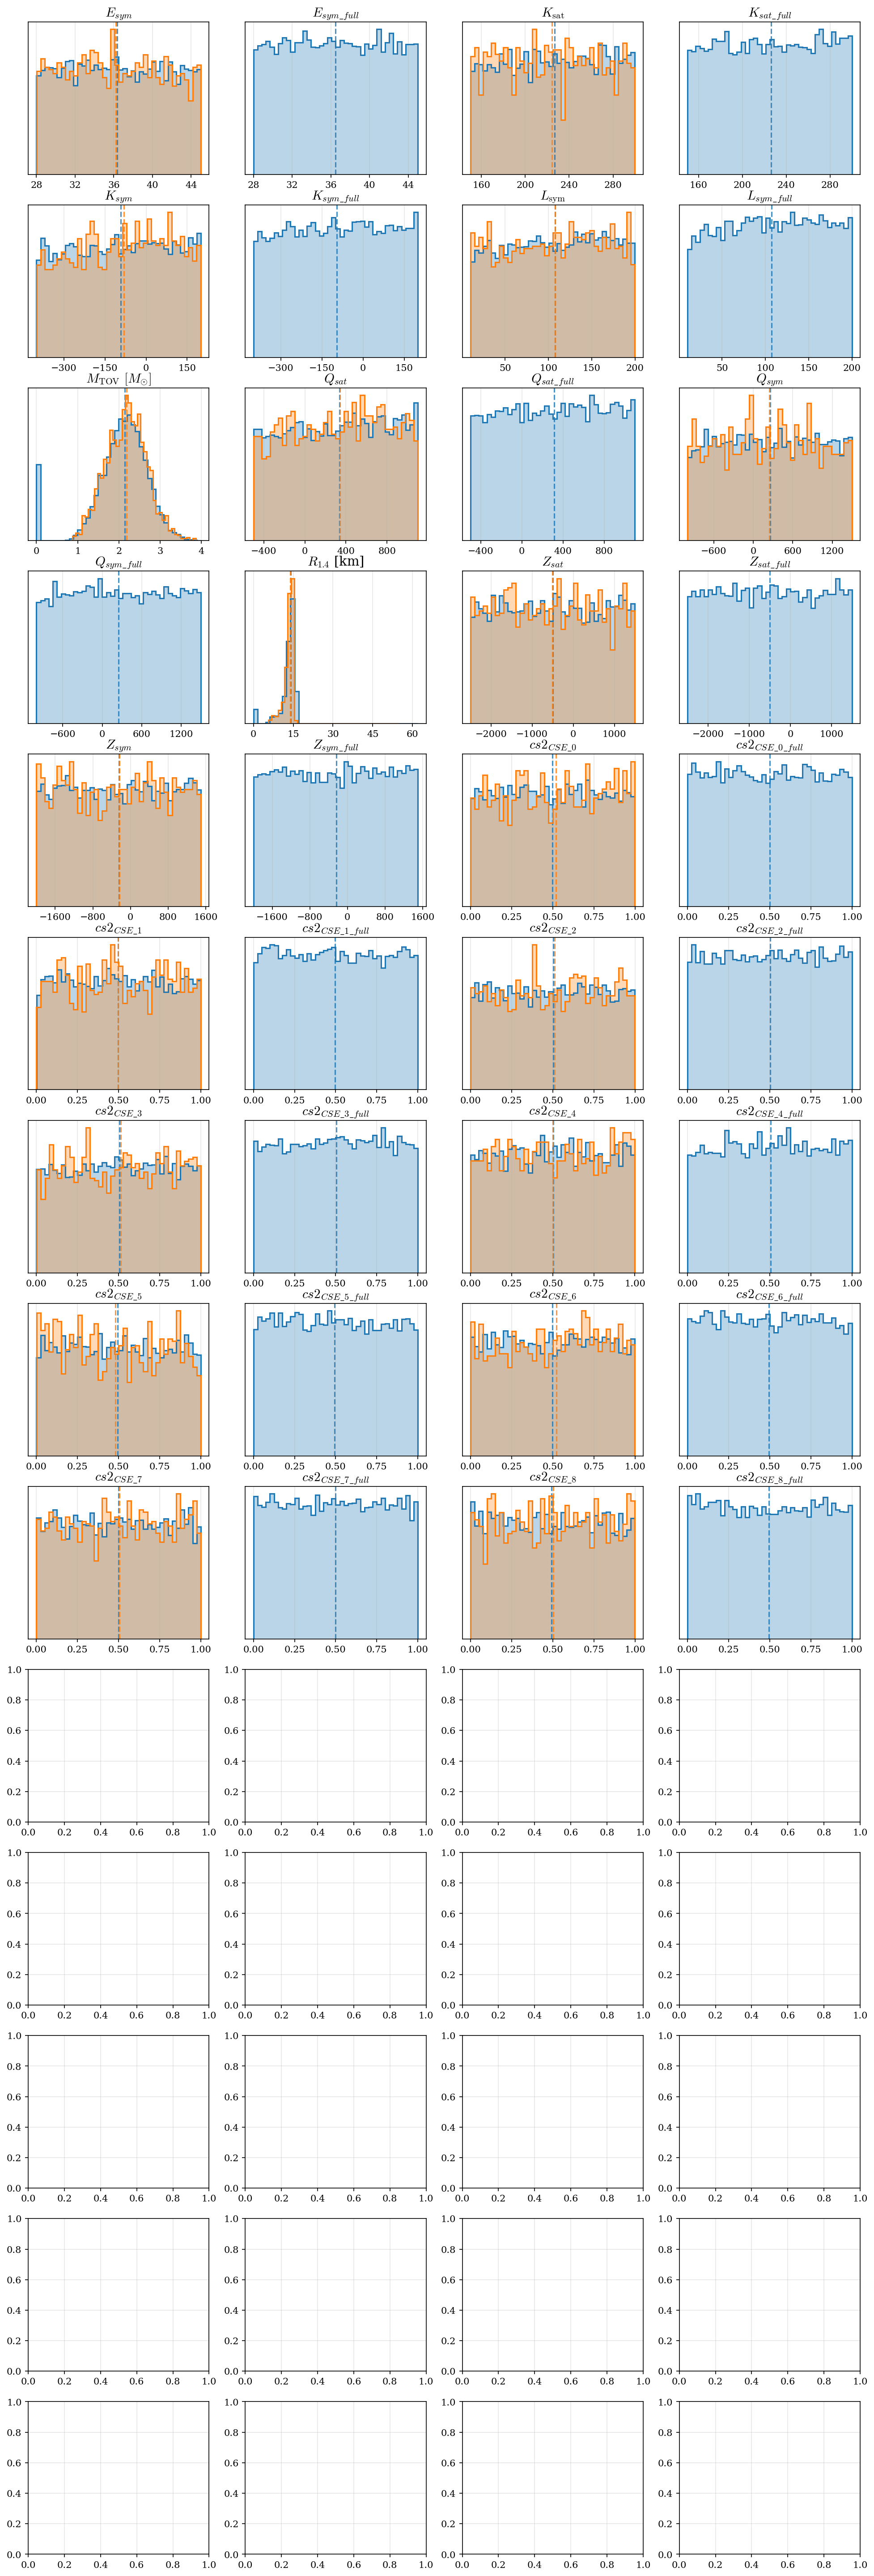

In [3]:
"""
Comparison Script for EOS Inference Results.
Automatically detects overlapping parameters and plots comparative histograms.
"""

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import logging
from scipy.stats import gaussian_kde
from matplotlib.ticker import MaxNLocator

# ==============================================================================
#                               USER CONFIGURATION
# ==============================================================================

FILE_1 = "smc_random_walk_exact_betaeq/prior/outdir/results.h5"
FILE_2 = "smc_random_walk/prior/outdir/results.h5"  # Comparison file

LABELS = ["prior - Exact", "prior - Approach"]  # Legend labels
COLORS = ["#1f77b4", "#ff7f0e"]  # Blue vs Orange (Standard accessible contrast)

PLOT_CONFIG = {
    "DPI": 150,
    "FIG_WIDTH": 16,     # Total width of the figure
    "COLS": 4,           # Number of columns in the subplot grid
    "BINS": 40,
    "USE_TEX": True
}

# ==============================================================================
#                                 CORE LOGIC
# ==============================================================================

logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger("comparator")

def setup_matplotlib():
    """Configures plot aesthetics."""
    plt.rcParams.update({
        "axes.grid": True, "grid.alpha": 0.3, "axes.labelsize": 12,
        "xtick.labelsize": 10, "ytick.labelsize": 10, "legend.fontsize": 10,
        "figure.titlesize": 16, "mathtext.fontset": "cm", "font.family": "serif"
    })
    if PLOT_CONFIG["USE_TEX"]:
        try:
            from matplotlib.checkdep_usetex import checkdep_usetex
            if checkdep_usetex(True):
                plt.rcParams.update({"text.usetex": True})
        except:
            pass

def get_fancy_label(name):
    """Generates LaTeX labels for parameters."""
    MAPPING = {
        'M_TOV': r'$M_{\rm{TOV}}$ $[M_{\odot}]$', 'R_1.4': r'$R_{1.4}$ [km]',
        'P_3nsat': r'$P(3n_{\rm{sat}})$ [MeV fm$^{-3}$]', 'L_sym': r'$L_{\rm{sym}}$',
        'K_sat': r'$K_{\rm{sat}}$', 'chi2': r'$\chi^2$', 'log_prob': r'$\ln \mathcal{L}$'
    }
    if name in MAPPING: return MAPPING[name]
    
    # Handle Greek letters and underscores
    parts = name.split('_')
    base = parts[0]
    if base in ['alpha', 'beta', 'gamma', 'delta', 'rho', 'sigma', 'kappa', 'lambda', 'epsilon']:
        base = f"\\{base}"
    
    if len(parts) > 1:
        sub = r'\_'.join(parts[1:])
        return f"${base}_{{{sub}}}$"
    return f"${base}$"

def load_params(filepath):
    """Loads parameters and computes derived scalars (M_TOV, etc) if missing."""
    if not os.path.exists(filepath):
        logger.warning(f"⚠️ File not found: {filepath}")
        return None

    with h5py.File(filepath, 'r') as f:
        if 'posterior' not in f: return None
        post = f['posterior']
        
        # Load explicit parameters
        data = {}
        if 'parameters' in post:
            for k in post['parameters'].keys():
                data[k] = post['parameters'][k][:]

        # Load or Compute Derived Scalars
        # We try to grab pre-computed ones, or compute from arrays if necessary
        eos_group = post.get('derived_eos', post)
        
        if 'M_TOV' not in data:
            # Quick computation of M_TOV from mass arrays if not stored as scalar
            try:
                masses = eos_group.get('masses_EOS', eos_group.get('masses'))[:]
                data['M_TOV'] = np.max(masses, axis=1)
            except: pass

        if 'R_1.4' not in data:
            try:
                masses = eos_group.get('masses_EOS', eos_group.get('masses'))[:]
                radii = eos_group.get('radii_EOS', eos_group.get('radii'))[:]
                r14 = []
                for m, r in zip(masses, radii):
                    # Sort to ensure interpolation works
                    srt = np.argsort(m)
                    r14.append(np.interp(1.4, m[srt], r[srt]))
                data['R_1.4'] = np.array(r14)
            except: pass

    return data

def plot_comparison(data1, data2):
    """Plots comparative histograms for all detected parameters."""
    
    # 1. Identify all unique keys
    keys1 = set(data1.keys()) if data1 else set()
    keys2 = set(data2.keys()) if data2 else set()
    all_keys = sorted(list(keys1.union(keys2)))
    
    # Filter out non-scalar arrays (just in case raw EOS curves got mixed in)
    valid_keys = []
    for k in all_keys:
        is_valid = False
        if k in keys1 and data1[k].ndim == 1: is_valid = True
        elif k in keys2 and data2[k].ndim == 1: is_valid = True
        
        # Skip constants (std dev == 0) to avoid plotting errors
        if is_valid:
            s1 = np.std(data1[k]) if k in keys1 else 1
            s2 = np.std(data2[k]) if k in keys2 else 1
            if s1 > 1e-12 or s2 > 1e-12:
                valid_keys.append(k)

    if not valid_keys:
        logger.error("❌ No valid 1D parameters found to compare.")
        return

    # 2. Setup Subplots
    n_plots = len(valid_keys)
    cols = PLOT_CONFIG["COLS"]
    rows = (n_plots + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(PLOT_CONFIG["FIG_WIDTH"], rows * 3.5), dpi=PLOT_CONFIG["DPI"])
    axes = axes.flatten() if n_plots > 1 else [axes]

    logger.info(f"📊 Generating comparison for {n_plots} parameters...")

    for i, param in enumerate(valid_keys):
        ax = axes[i]
        
        # --- Plot File 1 ---
        if k in keys1 and param in keys1:
            d1 = data1[param]
            # Remove NaNs/Infs
            d1 = d1[np.isfinite(d1)]
            
            # Histogram
            ax.hist(d1, bins=PLOT_CONFIG["BINS"], density=True, 
                    color=COLORS[0], alpha=0.3, label=LABELS[0] if i==0 else "")
            ax.hist(d1, bins=PLOT_CONFIG["BINS"], density=True, 
                    color=COLORS[0], histtype='step', linewidth=1.5)
            
            # Median Line
            ax.axvline(np.median(d1), color=COLORS[0], linestyle='--', alpha=0.8)

        # --- Plot File 2 ---
        if keys2 and param in keys2:
            d2 = data2[param]
            d2 = d2[np.isfinite(d2)]
            
            ax.hist(d2, bins=PLOT_CONFIG["BINS"], density=True, 
                    color=COLORS[1], alpha=0.3, label=LABELS[1] if i==0 else "")
            ax.hist(d2, bins=PLOT_CONFIG["BINS"], density=True, 
                    color=COLORS[1], histtype='step', linewidth=1.5)
            
            ax.axvline(np.median(d2), color=COLORS[1], linestyle='--', alpha=0.8)

        # Formatting
        ax.set_title(get_fancy_label(param), fontsize=14)
        ax.set_yticks([])
        ax.xaxis.set_major_locator(MaxNLocator(nbins=5)) # Prevent crowded x-ticks

    # Cleanup empty axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Global Legend
    if keys2:
        fig.legend(loc='upper center', ncol=2, frameon=False, fontsize=14, bbox_to_anchor=(0.5, 1.02))
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    setup_matplotlib()
    
    logger.info("⏳ Loading datasets...")
    d1 = load_params(FILE_1)
    d2 = load_params(FILE_2)

    if d1 is None and d2 is None:
        logger.error("💀 Bro, both files are missing or invalid. Check your paths!")
    elif d1 is None:
        logger.info("⚠️ File 1 missing. Plotting File 2 only.")
        plot_comparison({}, d2)
    elif d2 is None:
        logger.info("⚠️ File 2 missing. Plotting File 1 only.")
        plot_comparison(d1, {})
    else:
        plot_comparison(d1, d2)

⏳ Loading datasets...
📊 Generating comparison for 29 parameters...


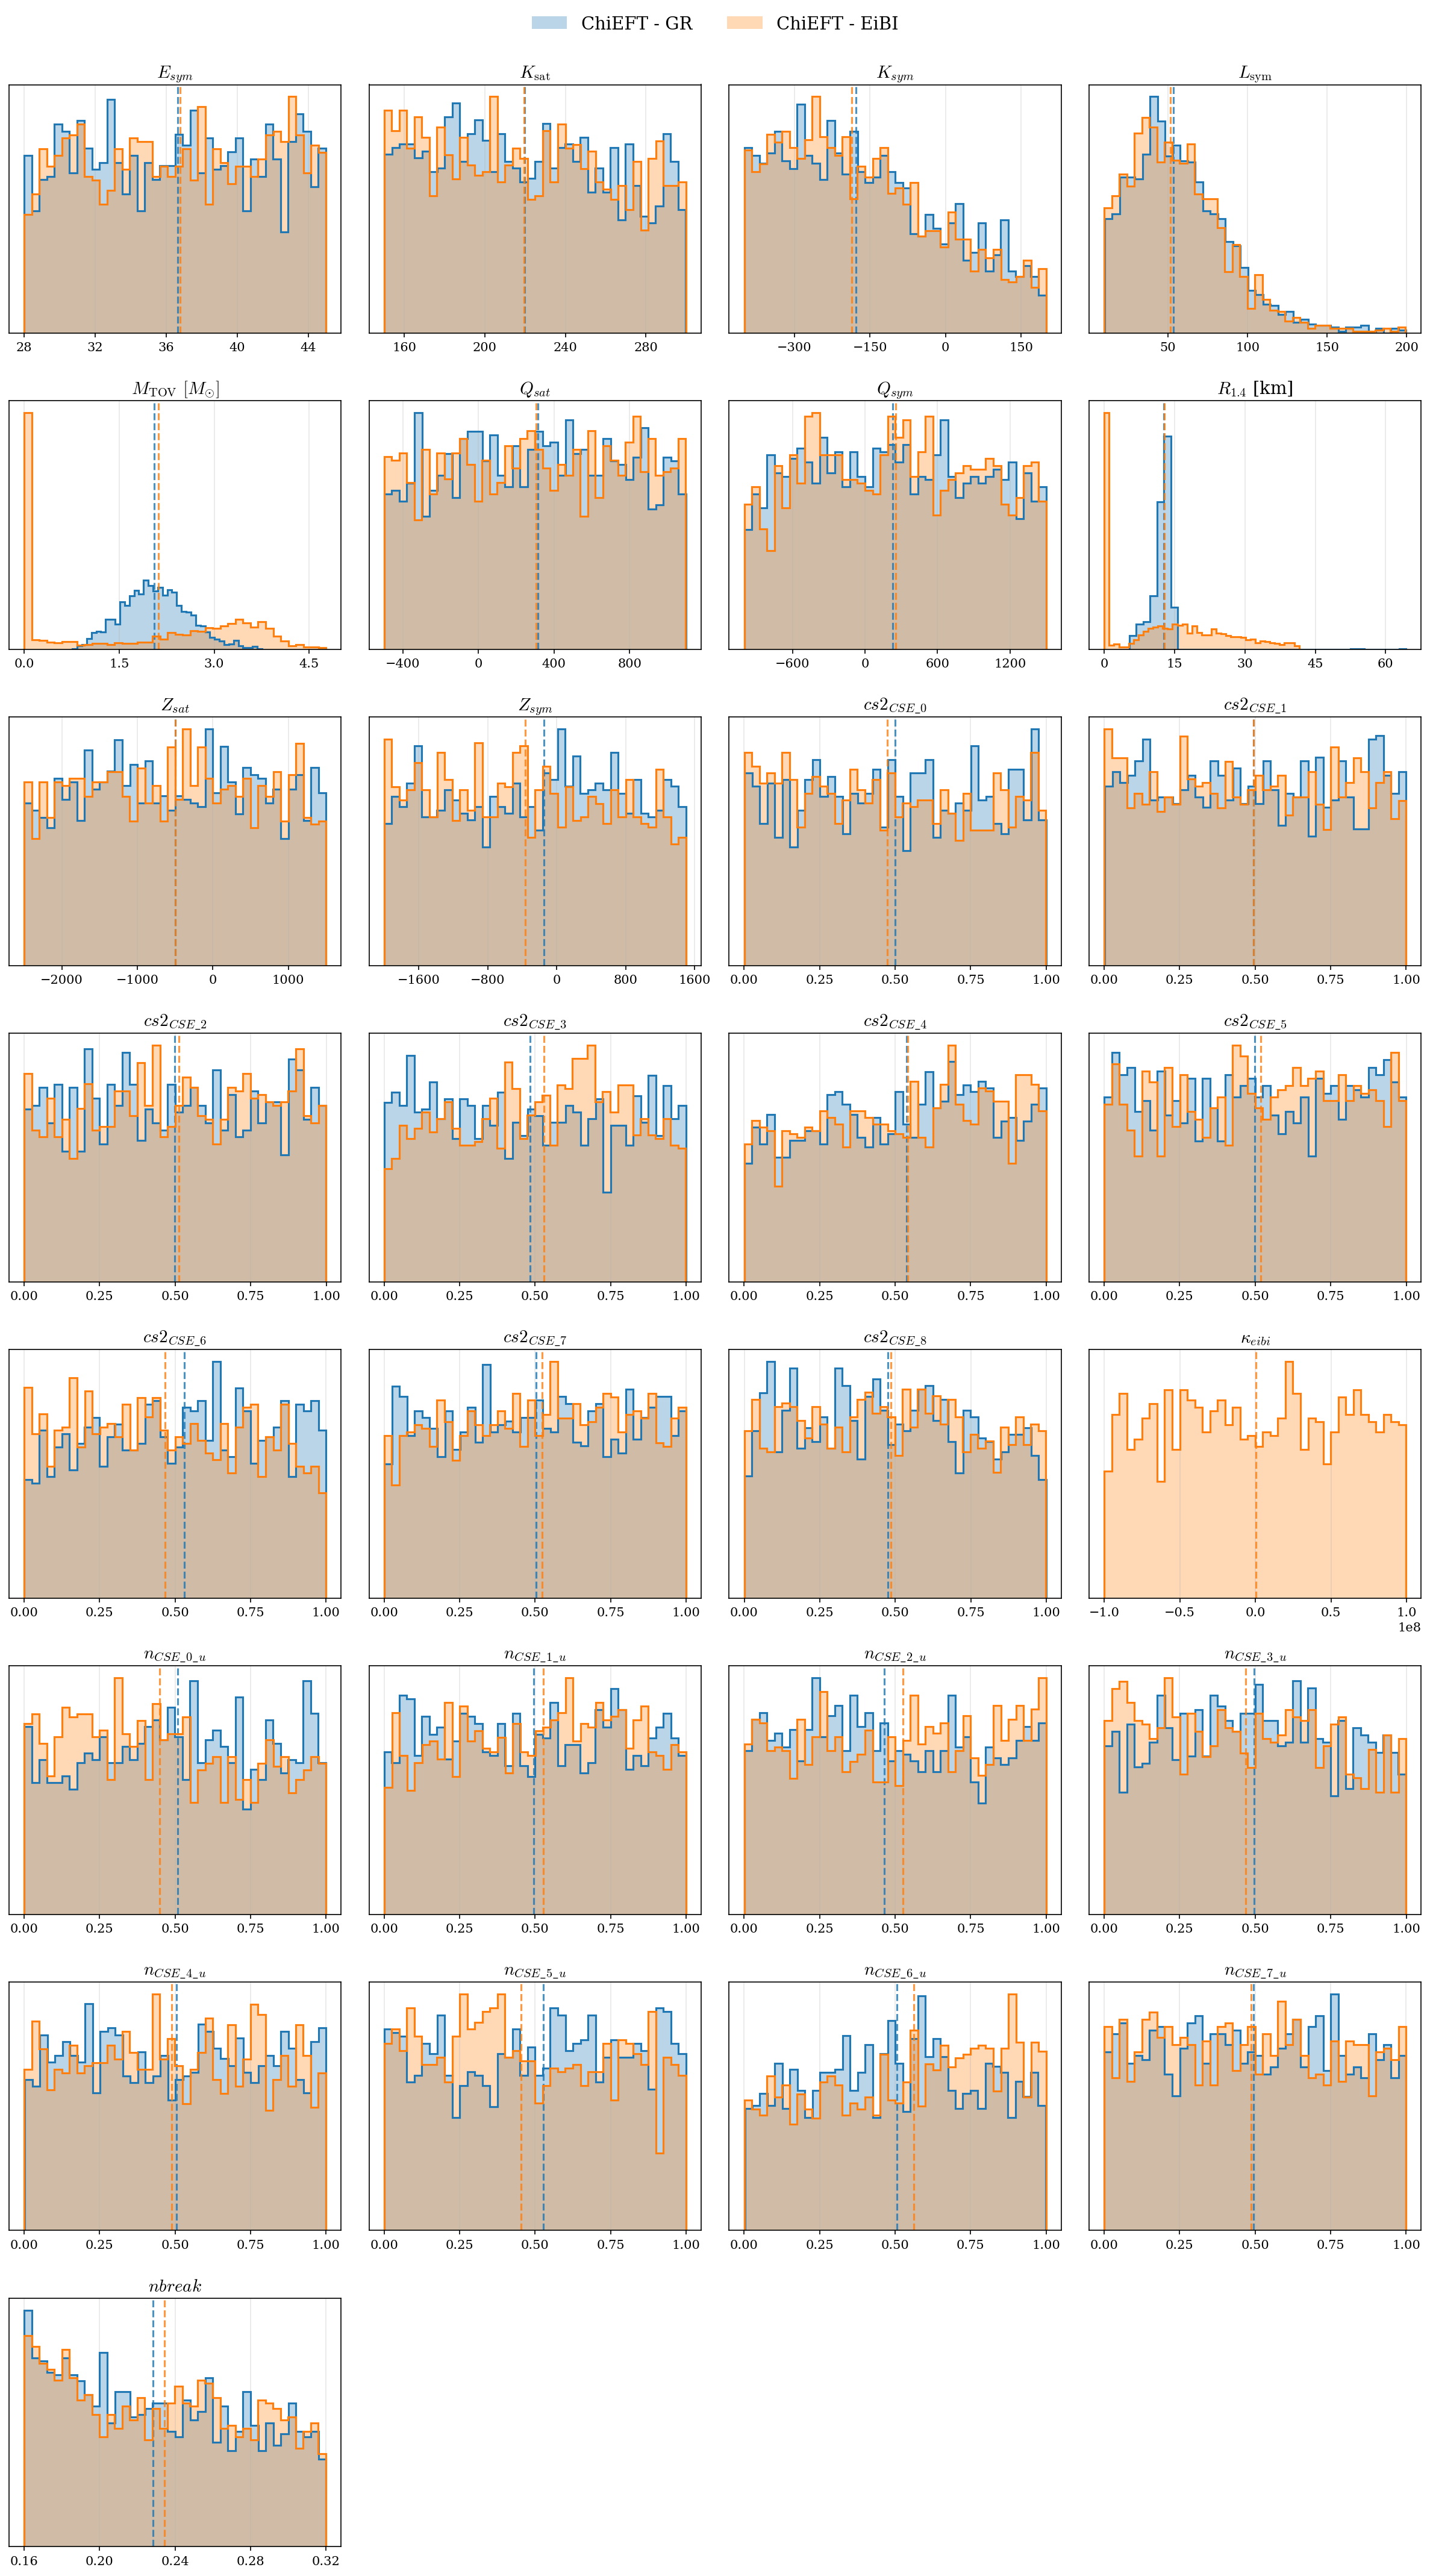

In [16]:
"""
Comparison Script for EOS Inference Results.
Automatically detects overlapping parameters and plots comparative histograms.
"""

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import logging
from scipy.stats import gaussian_kde
from matplotlib.ticker import MaxNLocator

# ==============================================================================
#                               USER CONFIGURATION
# ==============================================================================

FILE_1 = "smc_random_walk/chiEFT/outdir/results.h5"
FILE_2 = "smc_random_walk_eibi/chiEFT/outdir/results.h5"  # Comparison file

LABELS = ["ChiEFT - GR", "ChiEFT - EiBI"]  # Legend labels
COLORS = ["#1f77b4", "#ff7f0e"]  # Blue vs Orange (Standard accessible contrast)

PLOT_CONFIG = {
    "DPI": 150,
    "FIG_WIDTH": 16,     # Total width of the figure
    "COLS": 4,           # Number of columns in the subplot grid
    "BINS": 40,
    "USE_TEX": True
}

# ==============================================================================
#                                 CORE LOGIC
# ==============================================================================

logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger("comparator")

def setup_matplotlib():
    """Configures plot aesthetics."""
    plt.rcParams.update({
        "axes.grid": True, "grid.alpha": 0.3, "axes.labelsize": 12,
        "xtick.labelsize": 10, "ytick.labelsize": 10, "legend.fontsize": 10,
        "figure.titlesize": 16, "mathtext.fontset": "cm", "font.family": "serif"
    })
    if PLOT_CONFIG["USE_TEX"]:
        try:
            from matplotlib.checkdep_usetex import checkdep_usetex
            if checkdep_usetex(True):
                plt.rcParams.update({"text.usetex": True})
        except:
            pass

def get_fancy_label(name):
    """Generates LaTeX labels for parameters."""
    MAPPING = {
        'M_TOV': r'$M_{\rm{TOV}}$ $[M_{\odot}]$', 'R_1.4': r'$R_{1.4}$ [km]',
        'P_3nsat': r'$P(3n_{\rm{sat}})$ [MeV fm$^{-3}$]', 'L_sym': r'$L_{\rm{sym}}$',
        'K_sat': r'$K_{\rm{sat}}$', 'chi2': r'$\chi^2$', 'log_prob': r'$\ln \mathcal{L}$'
    }
    if name in MAPPING: return MAPPING[name]
    
    # Handle Greek letters and underscores
    parts = name.split('_')
    base = parts[0]
    if base in ['alpha', 'beta', 'gamma', 'delta', 'rho', 'sigma', 'kappa', 'lambda', 'epsilon']:
        base = f"\\{base}"
    
    if len(parts) > 1:
        sub = r'\_'.join(parts[1:])
        return f"${base}_{{{sub}}}$"
    return f"${base}$"

def load_params(filepath):
    """Loads parameters and computes derived scalars (M_TOV, etc) if missing."""
    if not os.path.exists(filepath):
        logger.warning(f"⚠️ File not found: {filepath}")
        return None

    with h5py.File(filepath, 'r') as f:
        if 'posterior' not in f: return None
        post = f['posterior']
        
        # Load explicit parameters
        data = {}
        if 'parameters' in post:
            for k in post['parameters'].keys():
                data[k] = post['parameters'][k][:]

        # Load or Compute Derived Scalars
        # We try to grab pre-computed ones, or compute from arrays if necessary
        eos_group = post.get('derived_eos', post)
        
        if 'M_TOV' not in data:
            # Quick computation of M_TOV from mass arrays if not stored as scalar
            try:
                masses = eos_group.get('masses_EOS', eos_group.get('masses'))[:]
                data['M_TOV'] = np.max(masses, axis=1)
            except: pass

        if 'R_1.4' not in data:
            try:
                masses = eos_group.get('masses_EOS', eos_group.get('masses'))[:]
                radii = eos_group.get('radii_EOS', eos_group.get('radii'))[:]
                r14 = []
                for m, r in zip(masses, radii):
                    # Sort to ensure interpolation works
                    srt = np.argsort(m)
                    r14.append(np.interp(1.4, m[srt], r[srt]))
                data['R_1.4'] = np.array(r14)
            except: pass

    return data

def plot_comparison(data1, data2):
    """Plots comparative histograms for all detected parameters."""
    
    # 1. Identify all unique keys
    keys1 = set(data1.keys()) if data1 else set()
    keys2 = set(data2.keys()) if data2 else set()
    all_keys = sorted(list(keys1.union(keys2)))
    
    # Filter out non-scalar arrays (just in case raw EOS curves got mixed in)
    valid_keys = []
    for k in all_keys:
        is_valid = False
        if k in keys1 and data1[k].ndim == 1: is_valid = True
        elif k in keys2 and data2[k].ndim == 1: is_valid = True
        
        # Skip constants (std dev == 0) to avoid plotting errors
        if is_valid:
            s1 = np.std(data1[k]) if k in keys1 else 1
            s2 = np.std(data2[k]) if k in keys2 else 1
            if s1 > 1e-12 or s2 > 1e-12:
                valid_keys.append(k)

    if not valid_keys:
        logger.error("❌ No valid 1D parameters found to compare.")
        return

    # 2. Setup Subplots
    n_plots = len(valid_keys)
    cols = PLOT_CONFIG["COLS"]
    rows = (n_plots + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(PLOT_CONFIG["FIG_WIDTH"], rows * 3.5), dpi=PLOT_CONFIG["DPI"])
    axes = axes.flatten() if n_plots > 1 else [axes]

    logger.info(f"📊 Generating comparison for {n_plots} parameters...")

    for i, param in enumerate(valid_keys):
        ax = axes[i]
        
        # --- Plot File 1 ---
        if k in keys1 and param in keys1:
            d1 = data1[param]
            # Remove NaNs/Infs
            d1 = d1[np.isfinite(d1)]
            
            # Histogram
            ax.hist(d1, bins=PLOT_CONFIG["BINS"], density=True, 
                    color=COLORS[0], alpha=0.3, label=LABELS[0] if i==0 else "")
            ax.hist(d1, bins=PLOT_CONFIG["BINS"], density=True, 
                    color=COLORS[0], histtype='step', linewidth=1.5)
            
            # Median Line
            ax.axvline(np.median(d1), color=COLORS[0], linestyle='--', alpha=0.8)

        # --- Plot File 2 ---
        if keys2 and param in keys2:
            d2 = data2[param]
            d2 = d2[np.isfinite(d2)]
            
            ax.hist(d2, bins=PLOT_CONFIG["BINS"], density=True, 
                    color=COLORS[1], alpha=0.3, label=LABELS[1] if i==0 else "")
            ax.hist(d2, bins=PLOT_CONFIG["BINS"], density=True, 
                    color=COLORS[1], histtype='step', linewidth=1.5)
            
            ax.axvline(np.median(d2), color=COLORS[1], linestyle='--', alpha=0.8)

        # Formatting
        ax.set_title(get_fancy_label(param), fontsize=14)
        ax.set_yticks([])
        ax.xaxis.set_major_locator(MaxNLocator(nbins=5)) # Prevent crowded x-ticks

    # Cleanup empty axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Global Legend
    if keys2:
        fig.legend(loc='upper center', ncol=2, frameon=False, fontsize=14, bbox_to_anchor=(0.5, 1.02))
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    setup_matplotlib()
    
    logger.info("⏳ Loading datasets...")
    d1 = load_params(FILE_1)
    d2 = load_params(FILE_2)

    if d1 is None and d2 is None:
        logger.error("💀 Bro, both files are missing or invalid. Check your paths!")
    elif d1 is None:
        logger.info("⚠️ File 1 missing. Plotting File 2 only.")
        plot_comparison({}, d2)
    elif d2 is None:
        logger.info("⚠️ File 2 missing. Plotting File 1 only.")
        plot_comparison(d1, {})
    else:
        plot_comparison(d1, d2)

⏳ Loading datasets...
🎨 Plotting 500 curves per file...


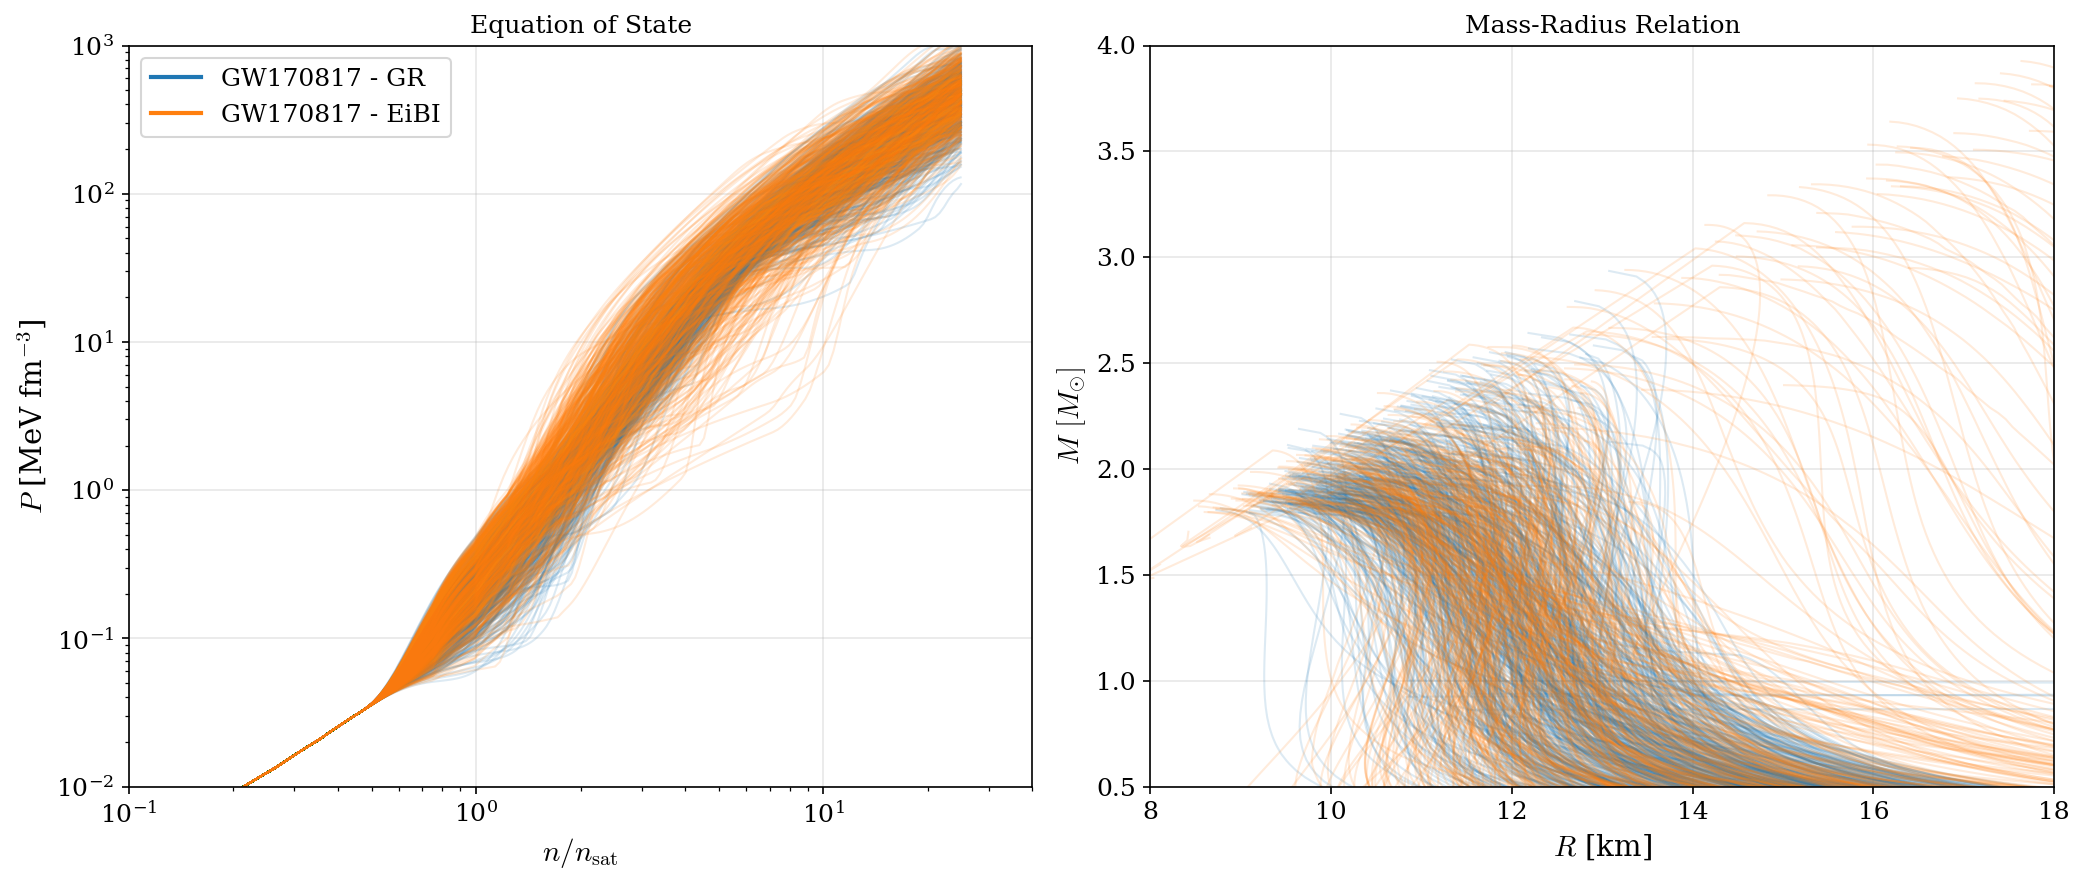

✅ Raw spaghetti plots generated.


In [14]:




"""
Raw Curve Comparison Script (Spaghetti Plot).
Plots individual posterior realizations without averaging or interpolation.
"""

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import logging
from matplotlib.collections import LineCollection

# ==============================================================================
#                               USER CONFIGURATION
# ==============================================================================

FILE_1 = "smc_random_walk/GW170817/outdir/results.h5"
FILE_2 = "smc_random_walk_eibi/GW170817/outdir/results.h5"  # Comparison file

LABELS = ["GW170817 - GR", "GW170817 - EiBI"]  # Legend labels
COLORS = ["#1f77b4", "#ff7f0e"]  # Blue vs Orange (Standard accessible contrast)

PLOT_CONFIG = {
    "DPI": 150,
    "FIG_SIZE": (14, 6),
    "USE_TEX": True,
    "NUM_SAMPLES": 500,      # Number of random curves to plot per file (Prevent lag)
    "ALPHA": 0.15,           # Transparency of each line (lower = better for overlaps)
    "LINEWIDTH": 1.0
}

N_SAT_SI = 0.16e45
GEOM_TO_MEVFM3 = 7.55e10

# ==============================================================================
#                                 CORE LOGIC
# ==============================================================================

logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger("raw_plotter")

def setup_matplotlib():
    plt.rcParams.update({
        "axes.grid": True, "grid.alpha": 0.3, "axes.labelsize": 14,
        "xtick.labelsize": 12, "ytick.labelsize": 12, "legend.fontsize": 12,
        "figure.titlesize": 16, "mathtext.fontset": "cm", "font.family": "serif"
    })
    if PLOT_CONFIG["USE_TEX"]:
        try:
            from matplotlib.checkdep_usetex import checkdep_usetex
            if checkdep_usetex(True):
                plt.rcParams.update({"text.usetex": True})
        except: pass

def load_curves(filepath):
    """Loads raw jagged arrays."""
    if not os.path.exists(filepath):
        logger.warning(f"⚠️ File not found: {filepath}")
        return None

    with h5py.File(filepath, 'r') as f:
        if 'posterior' not in f: return None
        post = f['posterior']
        group = post['derived_eos'] if 'derived_eos' in post else post
        
        if 'masses' not in group and 'masses_EOS' not in group:
            return None

        # Load raw data
        try:
            m = group.get('masses_EOS', group.get('masses'))[:]
            r = group.get('radii_EOS', group.get('radii'))[:]
            n = group.get('n')[:] / N_SAT_SI
            p = group.get('p')[:] * GEOM_TO_MEVFM3
            
            # Basic validation to remove empty/failed samples
            valid_idx = [i for i in range(len(m)) if len(m[i]) > 1]
            data = {
                'm': [m[i] for i in valid_idx],
                'r': [r[i] for i in valid_idx],
                'n': [n[i] for i in valid_idx],
                'p': [p[i] for i in valid_idx]
            }
        except Exception as e:
            logger.error(f"Failed to read data: {e}")
            return None
            
    return data

def get_segments(x_data, y_data, n_samples):
    """
    Selects random indices and formats them for LineCollection.
    Returns: list of segments [(x1,y1), (x2,y2)...], and valid indices
    """
    total = len(x_data)
    if total == 0: return [], []
    
    # Randomly sample indices
    N = min(total, n_samples)
    indices = np.random.choice(total, N, replace=False)
    
    segments = []
    for i in indices:
        # Stack into (N, 2) array for LineCollection
        # Filter NaNs or Infs just in case
        x, y = x_data[i], y_data[i]
        mask = np.isfinite(x) & np.isfinite(y) & (x > 0)
        
        if np.sum(mask) > 1:
            points = np.column_stack([x[mask], y[mask]])
            segments.append(points)
            
    return segments

def plot_raw(d1, d2):
    fig, (ax_eos, ax_mr) = plt.subplots(1, 2, figsize=PLOT_CONFIG["FIG_SIZE"], dpi=PLOT_CONFIG["DPI"])

    logger.info(f"🎨 Plotting {PLOT_CONFIG['NUM_SAMPLES']} curves per file...")

    # === 1. Equation of State (n vs P) ===
    lines_added = False
    for i, data in enumerate([d1, d2]):
        if data is None: continue
        
        # Prepare segments for LineCollection
        segs = get_segments(data['n'], data['p'], PLOT_CONFIG["NUM_SAMPLES"])
        
        if not segs: continue

        # Create Collection (Much faster than looping ax.plot)
        lc = LineCollection(segs, colors=COLORS[i], alpha=PLOT_CONFIG["ALPHA"], 
                            linewidths=PLOT_CONFIG["LINEWIDTH"])
        ax_eos.add_collection(lc)
        
        # Add dummy line for legend
        ax_eos.plot([], [], color=COLORS[i], label=LABELS[i], lw=2)
        lines_added = True

    ax_eos.set_xscale('log')
    ax_eos.set_yscale('log')
    ax_eos.set_xlabel(r"$n/n_{\rm{sat}}$")
    ax_eos.set_ylabel(r"$P$ [MeV fm$^{-3}$]")
    ax_eos.set_title("Equation of State")
    ax_eos.set_xlim(1e-1, 40)
    # Auto-scale Y based on dummy limits if needed, but manual is safer for log plots
    ax_eos.set_ylim(1e-2, 1000) 
    if lines_added: ax_eos.legend(loc='upper left')

    # === 2. Mass-Radius (R vs M) ===
    lines_added = False
    for i, data in enumerate([d1, d2]):
        if data is None: continue
        
        # Note: Plotting R on x-axis, M on y-axis
        segs = get_segments(data['r'], data['m'], PLOT_CONFIG["NUM_SAMPLES"])
        
        if not segs: continue

        lc = LineCollection(segs, colors=COLORS[i], alpha=PLOT_CONFIG["ALPHA"], 
                            linewidths=PLOT_CONFIG["LINEWIDTH"])
        ax_mr.add_collection(lc)
        lines_added = True

    ax_mr.set_xlabel(r"$R$ [km]")
    ax_mr.set_ylabel(r"$M$ $[M_{\odot}]$")
    ax_mr.set_title("Mass-Radius Relation")
    ax_mr.set_xlim(8, 18)
    ax_mr.set_ylim(0.5, 4)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    setup_matplotlib()
    
    logger.info("⏳ Loading datasets...")
    data1 = load_curves(FILE_1)
    data2 = load_curves(FILE_2)

    if data1 is None and data2 is None:
        logger.error("💀 Error: No valid data found.")
    else:
        plot_raw(data1, data2)
        logger.info("✅ Raw spaghetti plots generated.")

⏳ Loading datasets...
🎨 Plotting 500 curves per file...


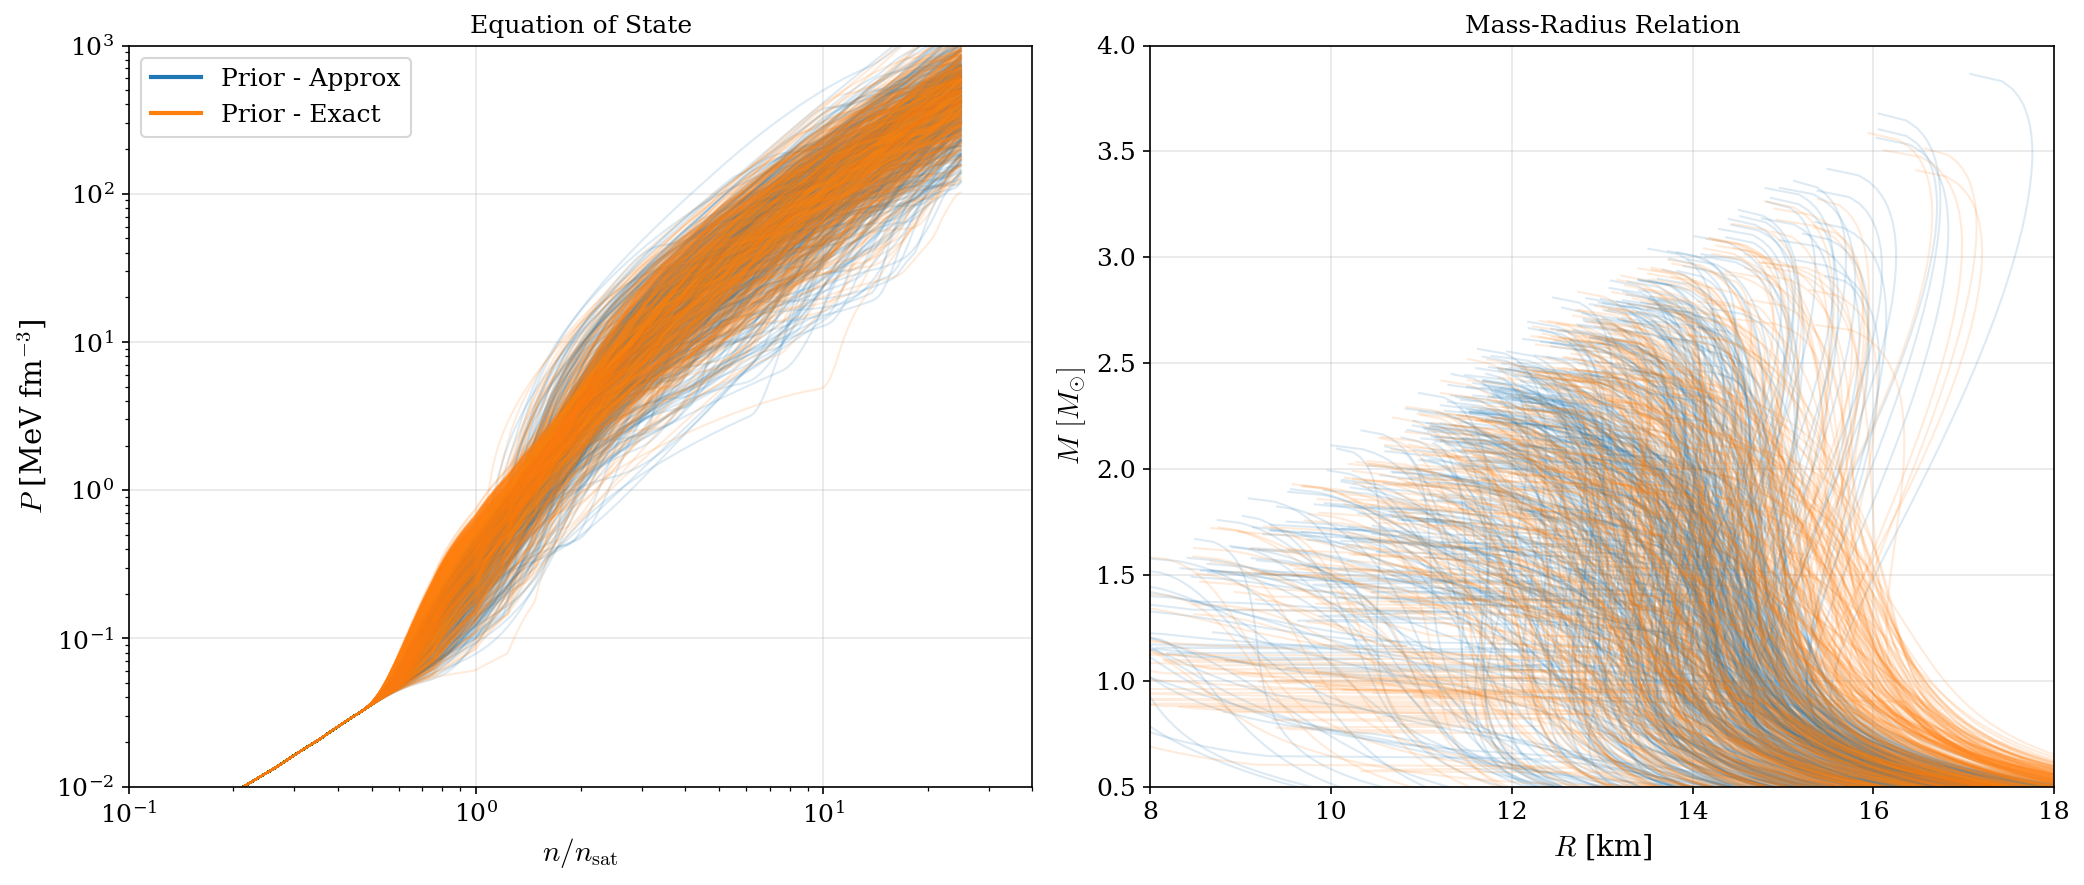

✅ Raw spaghetti plots generated.


In [23]:




"""
Raw Curve Comparison Script (Spaghetti Plot).
Plots individual posterior realizations without averaging or interpolation.
"""

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import logging
from matplotlib.collections import LineCollection

# ==============================================================================
#                               USER CONFIGURATION
# ==============================================================================

FILE_2 = "smc_random_walk_exact_betaeq/prior/outdir/results.h5"
FILE_1 = "smc_random_walk/prior/outdir/results.h5"  # Comparison file
LABELS = [ "Prior - Approx", "Prior - Exact"]
COLORS = ["#1f77b4", "#ff7f0e"]  # Blue vs Orange

PLOT_CONFIG = {
    "DPI": 150,
    "FIG_SIZE": (14, 6),
    "USE_TEX": True,
    "NUM_SAMPLES": 500,      # Number of random curves to plot per file (Prevent lag)
    "ALPHA": 0.15,           # Transparency of each line (lower = better for overlaps)
    "LINEWIDTH": 1.0
}

N_SAT_SI = 0.16e45
GEOM_TO_MEVFM3 = 7.55e10

# ==============================================================================
#                                 CORE LOGIC
# ==============================================================================

logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger("raw_plotter")

def setup_matplotlib():
    plt.rcParams.update({
        "axes.grid": True, "grid.alpha": 0.3, "axes.labelsize": 14,
        "xtick.labelsize": 12, "ytick.labelsize": 12, "legend.fontsize": 12,
        "figure.titlesize": 16, "mathtext.fontset": "cm", "font.family": "serif"
    })
    if PLOT_CONFIG["USE_TEX"]:
        try:
            from matplotlib.checkdep_usetex import checkdep_usetex
            if checkdep_usetex(True):
                plt.rcParams.update({"text.usetex": True})
        except: pass

def load_curves(filepath):
    """Loads raw jagged arrays."""
    if not os.path.exists(filepath):
        logger.warning(f"⚠️ File not found: {filepath}")
        return None

    with h5py.File(filepath, 'r') as f:
        if 'posterior' not in f: return None
        post = f['posterior']
        group = post['derived_eos'] if 'derived_eos' in post else post
        
        if 'masses' not in group and 'masses_EOS' not in group:
            return None

        # Load raw data
        try:
            m = group.get('masses_EOS', group.get('masses'))[:]
            r = group.get('radii_EOS', group.get('radii'))[:]
            n = group.get('n')[:] / N_SAT_SI
            p = group.get('p')[:] * GEOM_TO_MEVFM3
            
            # Basic validation to remove empty/failed samples
            valid_idx = [i for i in range(len(m)) if len(m[i]) > 1]
            data = {
                'm': [m[i] for i in valid_idx],
                'r': [r[i] for i in valid_idx],
                'n': [n[i] for i in valid_idx],
                'p': [p[i] for i in valid_idx]
            }
        except Exception as e:
            logger.error(f"Failed to read data: {e}")
            return None
            
    return data

def get_segments(x_data, y_data, n_samples):
    """
    Selects random indices and formats them for LineCollection.
    Returns: list of segments [(x1,y1), (x2,y2)...], and valid indices
    """
    total = len(x_data)
    if total == 0: return [], []
    
    # Randomly sample indices
    N = min(total, n_samples)
    indices = np.random.choice(total, N, replace=False)
    
    segments = []
    for i in indices:
        # Stack into (N, 2) array for LineCollection
        # Filter NaNs or Infs just in case
        x, y = x_data[i], y_data[i]
        mask = np.isfinite(x) & np.isfinite(y) & (x > 0)
        
        if np.sum(mask) > 1:
            points = np.column_stack([x[mask], y[mask]])
            segments.append(points)
            
    return segments

def plot_raw(d1, d2):
    fig, (ax_eos, ax_mr) = plt.subplots(1, 2, figsize=PLOT_CONFIG["FIG_SIZE"], dpi=PLOT_CONFIG["DPI"])

    logger.info(f"🎨 Plotting {PLOT_CONFIG['NUM_SAMPLES']} curves per file...")

    # === 1. Equation of State (n vs P) ===
    lines_added = False
    for i, data in enumerate([d1, d2]):
        if data is None: continue
        
        # Prepare segments for LineCollection
        segs = get_segments(data['n'], data['p'], PLOT_CONFIG["NUM_SAMPLES"])
        
        if not segs: continue

        # Create Collection (Much faster than looping ax.plot)
        lc = LineCollection(segs, colors=COLORS[i], alpha=PLOT_CONFIG["ALPHA"], 
                            linewidths=PLOT_CONFIG["LINEWIDTH"])
        ax_eos.add_collection(lc)
        
        # Add dummy line for legend
        ax_eos.plot([], [], color=COLORS[i], label=LABELS[i], lw=2)
        lines_added = True

    ax_eos.set_xscale('log')
    ax_eos.set_yscale('log')
    ax_eos.set_xlabel(r"$n/n_{\rm{sat}}$")
    ax_eos.set_ylabel(r"$P$ [MeV fm$^{-3}$]")
    ax_eos.set_title("Equation of State")
    ax_eos.set_xlim(1e-1, 40)
    # Auto-scale Y based on dummy limits if needed, but manual is safer for log plots
    ax_eos.set_ylim(1e-2, 1000) 
    if lines_added: ax_eos.legend(loc='upper left')

    # === 2. Mass-Radius (R vs M) ===
    lines_added = False
    for i, data in enumerate([d1, d2]):
        if data is None: continue
        
        # Note: Plotting R on x-axis, M on y-axis
        segs = get_segments(data['r'], data['m'], PLOT_CONFIG["NUM_SAMPLES"])
        
        if not segs: continue

        lc = LineCollection(segs, colors=COLORS[i], alpha=PLOT_CONFIG["ALPHA"], 
                            linewidths=PLOT_CONFIG["LINEWIDTH"])
        ax_mr.add_collection(lc)
        lines_added = True

    ax_mr.set_xlabel(r"$R$ [km]")
    ax_mr.set_ylabel(r"$M$ $[M_{\odot}]$")
    ax_mr.set_title("Mass-Radius Relation")
    ax_mr.set_xlim(8, 18)
    ax_mr.set_ylim(0.5, 4)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    setup_matplotlib()
    
    logger.info("⏳ Loading datasets...")
    data1 = load_curves(FILE_1)
    data2 = load_curves(FILE_2)

    if data1 is None and data2 is None:
        logger.error("💀 Error: No valid data found.")
    else:
        plot_raw(data1, data2)
        logger.info("✅ Raw spaghetti plots generated.")

⏳ Loading datasets...
🎨 Plotting 500 curves per file...
✅ ChiEFT limits overlay added (Direct Method).


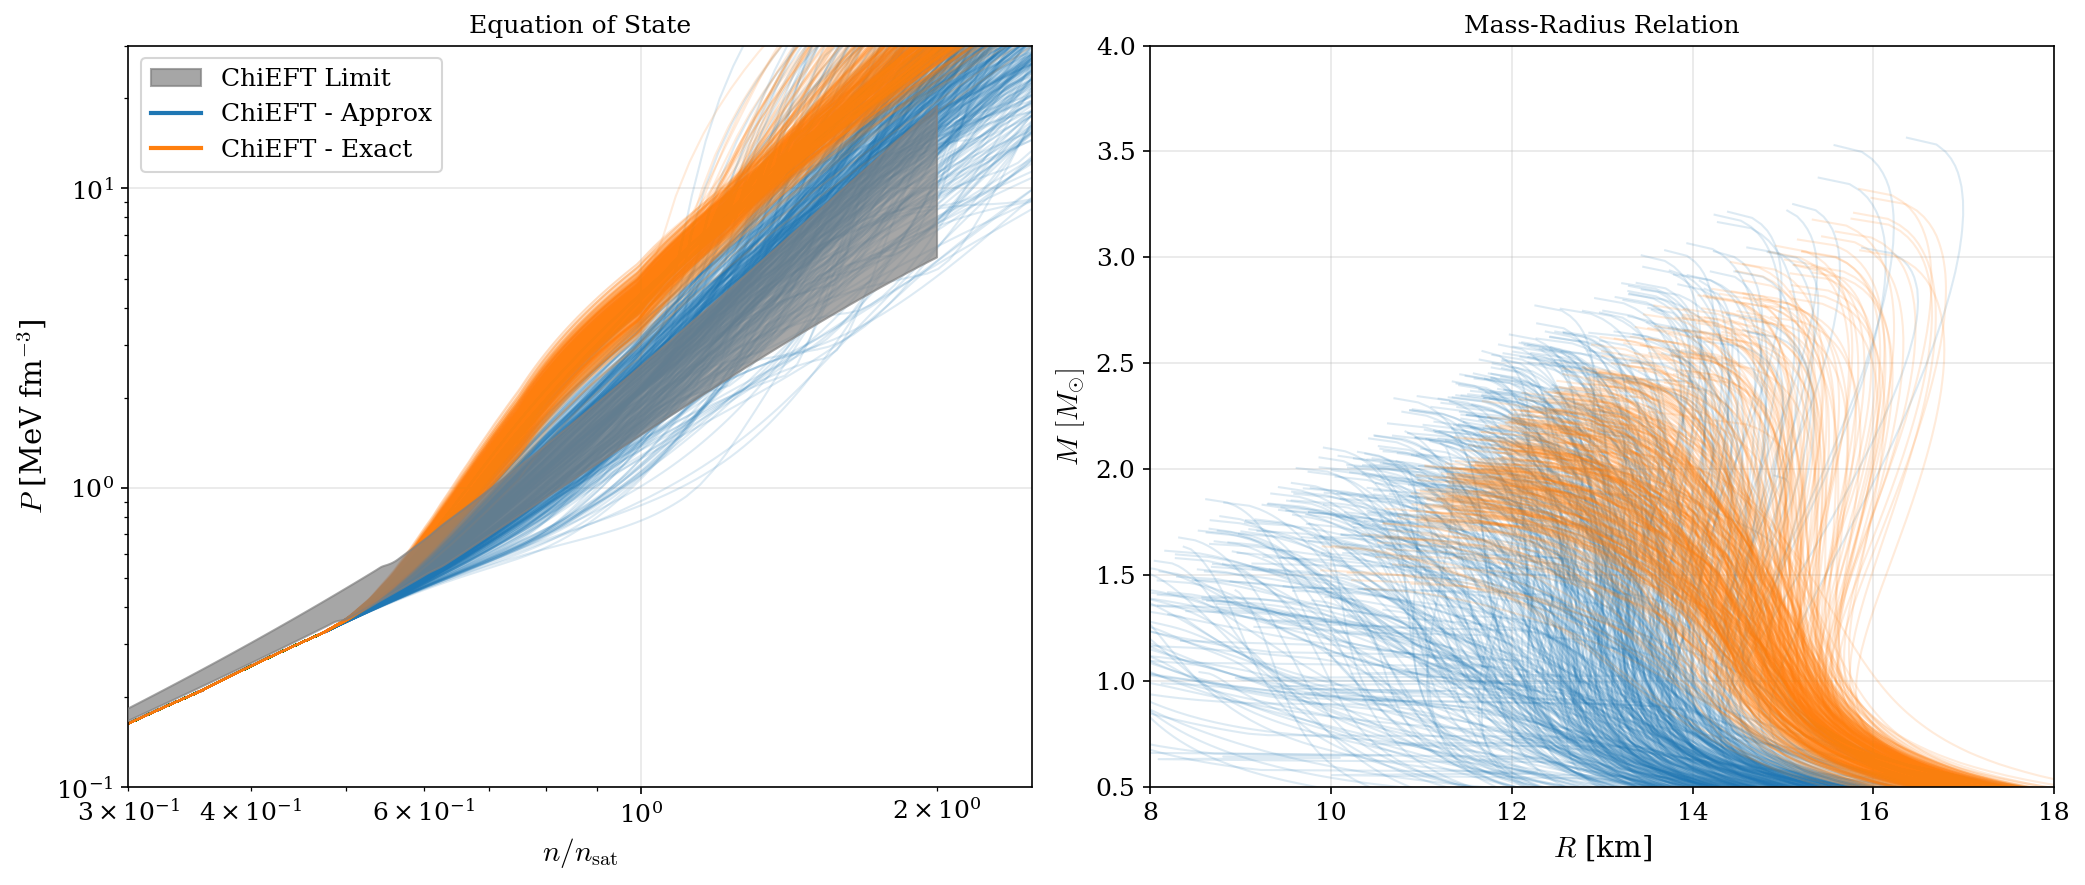

✅ Raw spaghetti plots generated.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import logging
from matplotlib.collections import LineCollection
from pathlib import Path
import jax
jax.config.update("jax_platforms", "cpu")
from jesterTOV import utils

# ==============================================================================
#                               USER CONFIGURATION
# ==============================================================================

FILE_2 = "smc_random_walk_exact_betaeq/chiEFT/outdir/results.h5"
FILE_1 = "smc_random_walk/chiEFT/outdir/results.h5"
LABELS = ["ChiEFT - Approx", "ChiEFT - Exact"]
COLORS = ["#1f77b4", "#ff7f0e"]

from pathlib import Path

try:
    # Lokasi: /home/.../jester/examples/inference/
    CURRENT_DIR = Path(__file__).resolve().parent
except NameError:
    CURRENT_DIR = Path.cwd()

# 1. Naik 2 level untuk sampai ke folder 'jester'
# parent[0] = inference, parent[1] = examples, parent[2] = jester
ROOT_JESTER = CURRENT_DIR.parents[1] 

# 2. Masuk ke jalur yang benar: jesterTOV/inference/
BASE_PATH = ROOT_JESTER / "jesterTOV" / "inference"

CHIEFT_CONFIG = {
    "DATA_DIR": BASE_PATH / "data" / "chiEFT" / "2402.04172",
    "LOW_FILE": "low.dat",
    "HIGH_FILE": "high.dat",
    "COLOR": "gray",
    "ALPHA": 0.7,
    "ZORDER": 10, 
}

PLOT_CONFIG = {
    "DPI": 150,
    "FIG_SIZE": (14, 6),
    "USE_TEX": True,
    "NUM_SAMPLES": 500,
    "ALPHA": 0.15,
    "LINEWIDTH": 1.0
}

N_SAT_FM = 0.16 # Standard saturation density in fm^-3
N_SAT_SI = N_SAT_SI = N_SAT_FM * utils.fm_inv3_to_SI

GEOM_TO_MEVFM3 = utils.geometric_to_MeV_fm_inv3

# ==============================================================================
#                                 CORE LOGIC
# ==============================================================================

logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger("raw_plotter")

def setup_matplotlib():
    plt.rcParams.update({
        "axes.grid": True, "grid.alpha": 0.3, "axes.labelsize": 14,
        "xtick.labelsize": 12, "ytick.labelsize": 12, "legend.fontsize": 12,
        "figure.titlesize": 16, "mathtext.fontset": "cm", "font.family": "serif"
    })
    if PLOT_CONFIG["USE_TEX"]:
        try:
            from matplotlib.checkdep_usetex import checkdep_usetex
            if checkdep_usetex(True):
                plt.rcParams.update({"text.usetex": True})
        except: pass

def load_curves(filepath):
    """Loads raw jagged arrays."""
    if not os.path.exists(filepath):
        logger.warning(f"⚠️ File not found: {filepath}")
        return None

    with h5py.File(filepath, 'r') as f:
        if 'posterior' not in f: return None
        post = f['posterior']
        group = post['derived_eos'] if 'derived_eos' in post else post
        
        if 'masses' not in group and 'masses_EOS' not in group:
            return None

        try:
            m = group.get('masses_EOS', group.get('masses'))[:]
            r = group.get('radii_EOS', group.get('radii'))[:]
            n = group.get('n')[:] / N_SAT_SI
            p = group.get('p')[:] * GEOM_TO_MEVFM3
            
            valid_idx = [i for i in range(len(m)) if len(m[i]) > 1]
            data = {
                'm': [m[i] for i in valid_idx],
                'r': [r[i] for i in valid_idx],
                'n': [n[i] for i in valid_idx],
                'p': [p[i] for i in valid_idx]
            }
        except Exception as e:
            logger.error(f"Failed to read data: {e}")
            return None
            
    return data

def get_segments(x_data, y_data, n_samples):
    """Selects random indices and formats them for LineCollection."""
    total = len(x_data)
    if total == 0: return [], []
    
    N = min(total, n_samples)
    indices = np.random.choice(total, N, replace=False)
    
    segments = []
    for i in indices:
        x, y = x_data[i], y_data[i]
        mask = np.isfinite(x) & np.isfinite(y) & (x > 0)
        
        if np.sum(mask) > 1:
            points = np.column_stack([x[mask], y[mask]])
            segments.append(points)
            
    return segments

def plot_chieft_limits(ax):
    """
    Parses ChiEFT .dat files and plots the filled region directly using the 
    method from the reference script (no interpolation).
    """
    # Resolve paths
    base_dir = CHIEFT_CONFIG["DATA_DIR"]
    
    # Handle relative paths if necessary
    if not base_dir.is_absolute():
        base_dir = Path.cwd() / base_dir 

    low_path = base_dir / CHIEFT_CONFIG["LOW_FILE"]
    high_path = base_dir / CHIEFT_CONFIG["HIGH_FILE"]

    if not low_path.exists() or not high_path.exists():
        logger.warning(f"⚠️ ChiEFT data files not found at {base_dir}. Skipping overlay.")
        return

    try:
        # Load Data
        # Column 0: Density n [fm^-3]
        # Column 1: Pressure P [MeV/fm^3]
        low_data = np.loadtxt(low_path)
        high_data = np.loadtxt(high_path)

        # Validation: The reference method assumes identical density grids.
        # We check lengths to avoid shape mismatch errors in fill_between.
        if low_data.shape != high_data.shape:
             logger.warning("⚠️ ChiEFT data shape mismatch. Fallback to common length slicing.")
             min_len = min(len(low_data), len(high_data))
             low_data = low_data[:min_len]
             high_data = high_data[:min_len]

        # Extract columns
        n_low = low_data[:, 0]  # Density in fm^-3
        p_low = low_data[:, 1]  # Pressure
        
        # We strictly use the density grid from low_data for the x-axis, 
        # consistent with the reference script: ax.fill_between(n_low, p_low, p_high, ...)
        p_high = high_data[:, 1]

        # Unit Conversion: n -> n/n_sat
        n_plot = n_low / N_SAT_FM

        # Plot directly without re-gridding
        ax.fill_between(
            n_plot, 
            p_low, 
            p_high, 
            color=CHIEFT_CONFIG["COLOR"], 
            alpha=CHIEFT_CONFIG["ALPHA"], 
            zorder=CHIEFT_CONFIG["ZORDER"],
            label="ChiEFT Limit"
        )
        
        logger.info("✅ ChiEFT limits overlay added (Direct Method).")

    except Exception as e:
        logger.error(f"❌ Failed to plot ChiEFT limits: {e}")

def plot_raw(d1, d2):
    fig, (ax_eos, ax_mr) = plt.subplots(1, 2, figsize=PLOT_CONFIG["FIG_SIZE"], dpi=PLOT_CONFIG["DPI"])

    logger.info(f"🎨 Plotting {PLOT_CONFIG['NUM_SAMPLES']} curves per file...")

    # === 1. Equation of State (n vs P) ===
    
    # >> ADDED: Plot ChiEFT limits first (background)
    plot_chieft_limits(ax_eos)

    lines_added = False
    for i, data in enumerate([d1, d2]):
        if data is None: continue
        
        segs = get_segments(data['n'], data['p'], PLOT_CONFIG["NUM_SAMPLES"])
        if not segs: continue

        lc = LineCollection(segs, colors=COLORS[i], alpha=PLOT_CONFIG["ALPHA"], 
                            linewidths=PLOT_CONFIG["LINEWIDTH"])
        ax_eos.add_collection(lc)
        
        ax_eos.plot([], [], color=COLORS[i], label=LABELS[i], lw=2)
        lines_added = True

    ax_eos.set_xscale('log')
    ax_eos.set_yscale('log')
    ax_eos.set_xlabel(r"$n/n_{\rm{sat}}$")
    ax_eos.set_ylabel(r"$P$ [MeV fm$^{-3}$]")
    ax_eos.set_title("Equation of State")
    ax_eos.set_xlim(3e-1, 2.5)
    ax_eos.set_ylim(1e-1, 30) 
    if lines_added: ax_eos.legend(loc='upper left')

    # === 2. Mass-Radius (R vs M) ===
    lines_added = False
    for i, data in enumerate([d1, d2]):
        if data is None: continue
        
        segs = get_segments(data['r'], data['m'], PLOT_CONFIG["NUM_SAMPLES"])
        if not segs: continue

        lc = LineCollection(segs, colors=COLORS[i], alpha=PLOT_CONFIG["ALPHA"], 
                            linewidths=PLOT_CONFIG["LINEWIDTH"])
        ax_mr.add_collection(lc)
        lines_added = True

    ax_mr.set_xlabel(r"$R$ [km]")
    ax_mr.set_ylabel(r"$M$ $[M_{\odot}]$")
    ax_mr.set_title("Mass-Radius Relation")
    ax_mr.set_xlim(8, 18)
    ax_mr.set_ylim(0.5, 4)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    setup_matplotlib()
    
    logger.info("⏳ Loading datasets...")
    data1 = load_curves(FILE_1)
    data2 = load_curves(FILE_2)

    if data1 is None and data2 is None:
        logger.error("💀 Error: No valid data found.")
    else:
        plot_raw(data1, data2)
        logger.info("✅ Raw spaghetti plots generated.")